In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
plt.rc("figure", dpi=300, figsize=(9,3))
np.random.seed(2021)

<h1 align="center">Titanic Survival Estimation via Naïve Bayes</h1>
<h2 align="center">Angela Cao</h2>
<h5 align="center">Fall 2020 Directed Readings Program, University of Texas at Austin Department of Mathematics</h4>
<h5 align="center">Advised by Shane McQuarrie</h4>

## Contents

1. [**Introduction: The Titanic Problem**](#Introduction:-The-Titanic-Problem)
2. [**Brief Data Summary**](#Brief-Data-Summary)
3. [**The Naïve Bayes Algorithm**](#The-Naïve-Bayes-Algorithm)
4. [**Applying the Algorithm**](#Applying-the-Algorithm)

## Introduction: The Titanic Problem

On April 15, 1912, the [RMS Titanic](https://en.wikipedia.org/wiki/Titanic) sank, leaving about 1,500 people dead. The goal of this project is to construct a machine learning algorithm to predict whether or not a person with given characteristics would have been likely to survive the accident. This is a [popular problem](https://www.kaggle.com/c/titanic) for a first-time exposure to machine learning.

We have a [data set](https://www.kaggle.com/c/titanic/data) with information about 1,308 of the Titanic passengers, with the following features for each passenger. We begin by loading the data and displaying a few random entries.

In [3]:
# Read the data from file.
titanic_original = pd.read_csv("titanic.csv")
titanic_original.sample(5)

,Pclass,Survived,Name,Sex,Age,Sibsp,Parch,Ticket,Fare,Cabin,Embarked,Boat,Body,home.dest
1245,3,0,"Thomson, Mr. Alexander Morrison",male,NaN,0,0,32302,8.05,NaN,S,NaN,NaN,NaN
745,3,1,"Daly, Miss. Margaret Marcella ""Maggie""",female,30.0,0,0,382650,6.95,NaN,Q,15,NaN,"Co Athlone, Ireland New York, NY"
544,2,0,"Renouf, Mr. Peter Henry",male,34.0,1,0,31027,21.00,NaN,S,12,NaN,"Elizabeth, NJ"
1269,3,0,"Vande Velde, Mr. Johannes Joseph",male,33.0,0,0,345780,9.50,NaN,S,NaN,NaN,NaN
1040,3,1,"Mulvihill, Miss. Bertha E",female,24.0,0,0,382653,7.75,NaN,Q,15,NaN,NaN


Which of these features differentiate a survivor from a nonsurvivor? We restrict our attention to the following features:
- `Sex`: the sex of the passenger, either `male` or `female`.
- `Age`: the age of the passenger, usually recorded as a positive integer.
- `Pclass`: the class of the passenger's ticket, 1 for first class (the best), 2 for second class, and 3 for third class (the worst).
- `Fare`: the cost of the passenger's ticket.

Some of the other columns in the data may be useful, but certainly these features are more important survival indicators than, for example, the passenger `Name`.

In [4]:
# Extract the relevant columns.
titanic = titanic_original[["Survived", "Sex", "Age", "Pclass", "Fare"]]
titanic.sample(5)

,Survived,Sex,Age,Pclass,Fare
1294,0,male,28.5,3,16.1000
32,1,female,30.0,1,164.8667
102,1,female,23.0,1,83.1583
572,1,female,28.0,2,12.6500
871,0,male,NaN,3,7.7500


Before any analysis, we split the data into _training_ and _testing_ sets, reserving 15% of the entries for testing. We are only allowed to use the testing set to evaluate the performance of our algorithm later on. Since some of the entries of the data may be missing (for example, some passengers don't have a recorded age), we replace missing values of the test data with the column averages of the training data.

In [5]:
# Split the data into training and testing sets.
train_data, test_data = train_test_split(titanic, test_size=.15)
print(f"{len(train_data)} train points, {len(test_data)} test points ({len(titanic)} total)")

# Separate the Survival labels from the test data and replace
# missing values with the averages from the training data.
test_labels = test_data["Survived"]
test_data = test_data.drop("Survived", axis=1).fillna(train_data.mean())

test_data.sample(3)

1112 train points, 197 test points (1309 total)


,Sex,Age,Pclass,Fare
322,female,36.000000,1,135.6333
865,female,29.901089,3,7.7500
486,male,24.000000,2,10.5000


## Brief Data Summary

We now give a brief statistical overview of the training data (remember, we aren't allowed to even look at the testing data). First, what was the rate of survival?

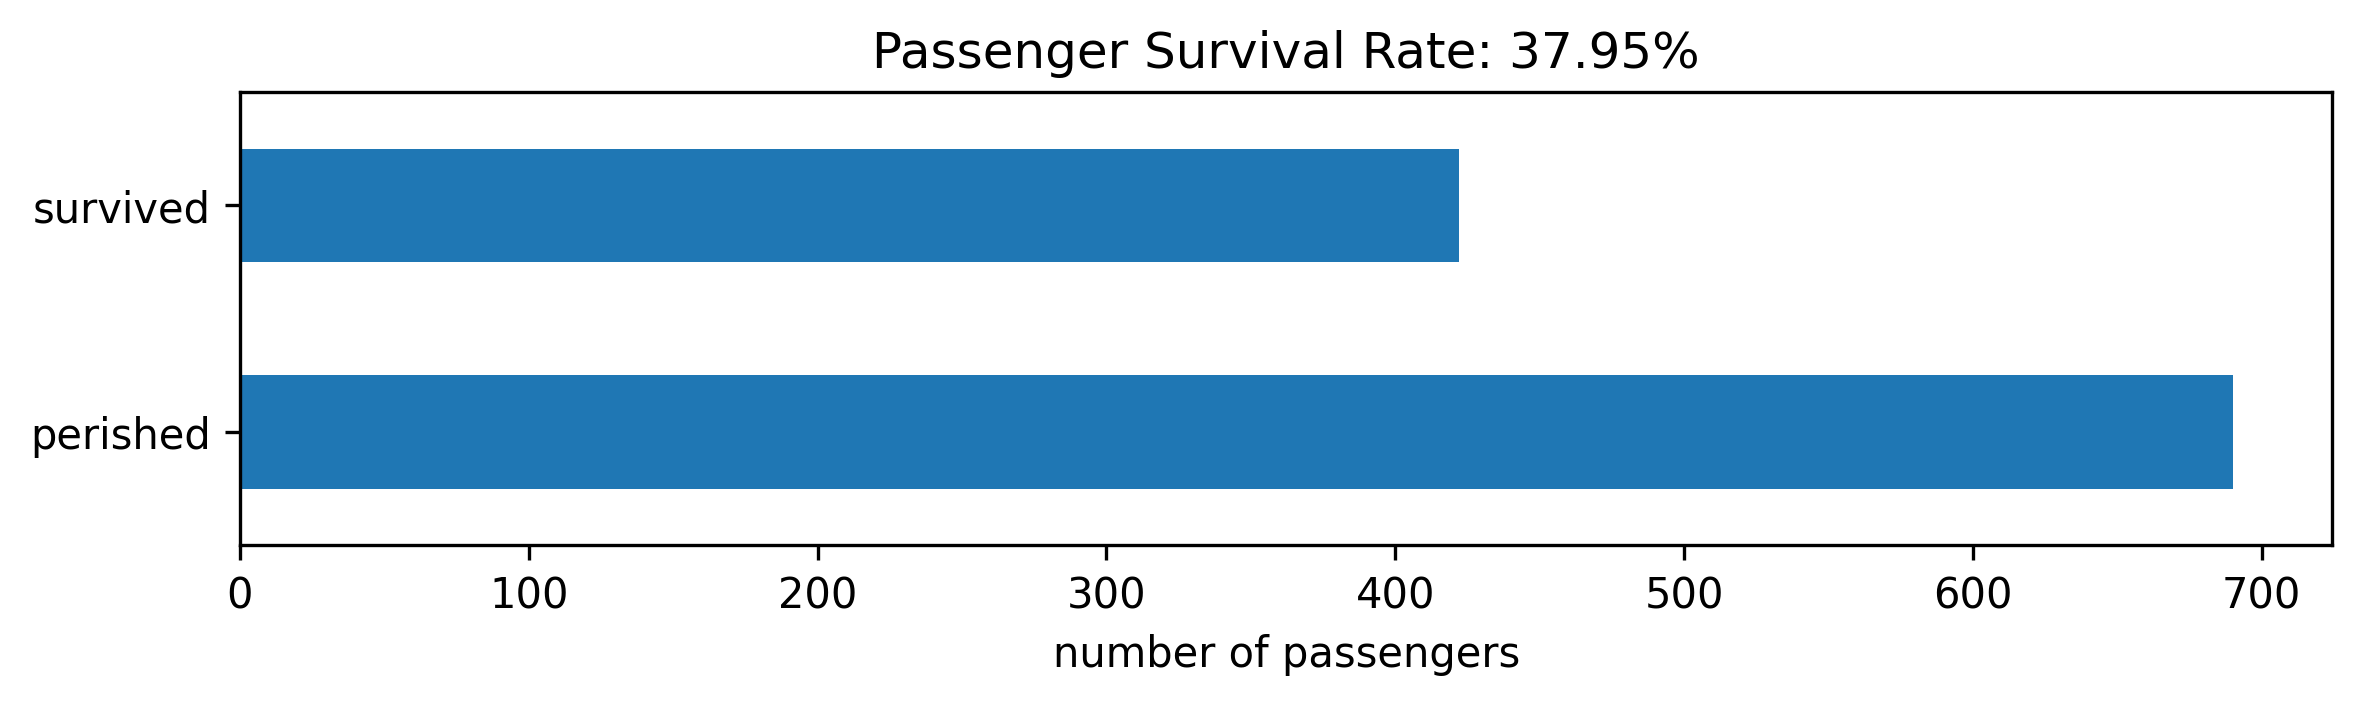

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(9, 2))

survival_count = train_data.groupby("Survived").count().max(axis=1)
survival_count.plot(kind="barh", ax=ax)

ax.set_ylabel(""); ax.set_yticklabels(["perished", "survived"])
ax.set_xlabel("number of passengers")
ax.set_title(f"Passenger Survival Rate: {survival_count[1] / sum(survival_count):.2%}")
plt.show()

The survival rate (according to the training data) is around 40%. Without any further information about the passengers, we could assign every passenger in the test set a 40% survival probability. But we want survival probabilities that are tailored to each individual based on their individual features; that's the goal of our algorithm.

Note that both groups, survivors and non-survivors, have several hundred members. These are large enough populations for us to legitimately consider an algorithm that relies on constructing approximate statistical distributions for each group.

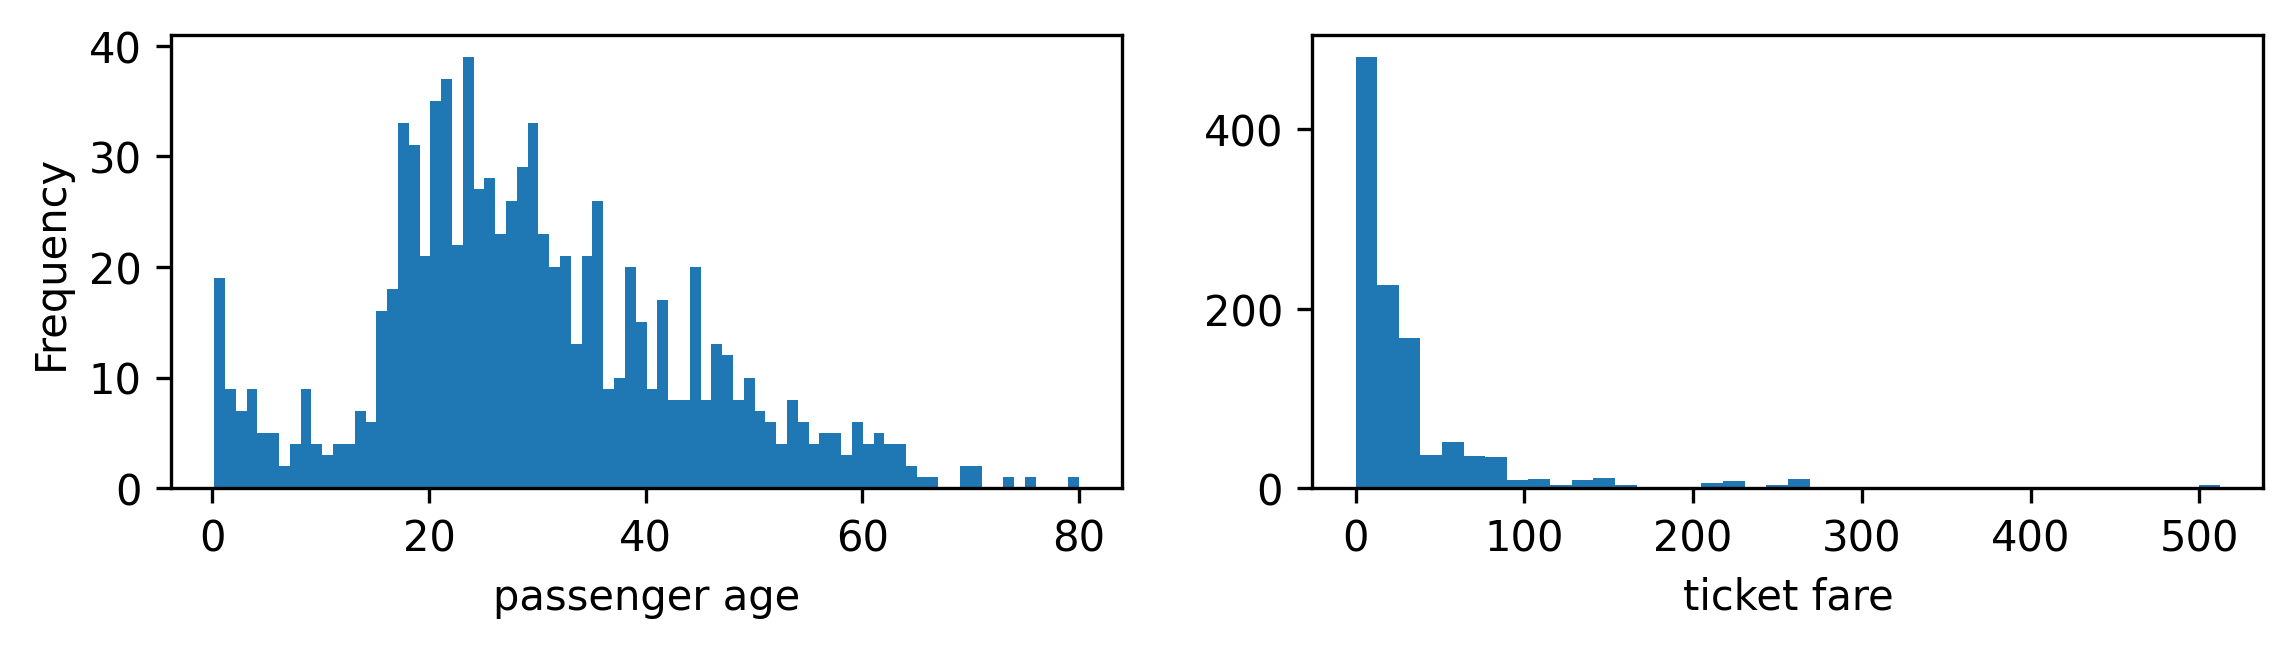

In [7]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(9,2))

train_data["Age"].plot(kind="hist", bins=80, ax=ax1)
ax1.set_xlabel("passenger age")

train_data["Fare"].plot(kind="hist", bins=40, ax=ax2)
ax2.set_ylabel(""); ax2.set_xlabel("ticket fare")
plt.show()

The histogram on the left shows the distribution of the ages of the passengers in the training data. There are many passengers in their 20's and 30's, few teenagers, and a sizeable number of children. The distribution is slightly right-skewed, but it could be approximated fairly well with a normal (Gaussian) distribution.

The histogram on the right shows the distribution of the ticket prices of the passengers in the training data. This distribution is extremely right-skewed: the overwhelming majority of passengers having tickets that cost \$100  or less, but a few outliers have far more expensive tickets.

Next, we briefly look for statistical differences between survivors and nonsurvivors.

In [8]:
train_data.groupby(["Survived"]).mean()

,Age,Pclass,Fare
Survived,,,
0,30.573881,2.507246,22.975780
1,28.909703,1.971564,49.429276


This table sorts the data by the survival label (0 for non-survivors and 1 for survivors), then computes mean of the features for each group. A few things are immediately apparent:
- Survivors had, on average, significantly more expensive tickets than non-survivors. This is due at least in part to the presence of the outliers observed above in the ticket price distribution.
- Survivors, on average, were in a (slightly) higher class than non-survivors (recall Pclass = 1 means a first-class ticket). In other words, holding all other features equal, first-class passengers are more likely to survive than second-class passengers.
- The average ages for survivors and non-survivors are relatively similar, with survivors being just two years younger than non-survirors on average.

In short, the survivors and non-survivors exhibit different statistics; we aim to use that information to construct a "survival classifier."

## The Naïve Bayes Algorithm

Our goal is to construct a function that maps a given tuple of `Sex`, `Age`, `Pclass`, and `Fare` values to a `Survival` value (0 for perished or 1 for survived).
There are many ways to construct such a function, but we will use the simple Naïve Bayes algorithm.
This is a _binary classification problem_ because we are separating instances of data into two categories, and since we have labeled data to train on, this is an example of _supervised learning_. Naïve Bayes can also be used for multi-class classification (more than two categories to sort the data into), but we restrict ourselves to the binary case for ease of exposition. We will first develop the algorithm generally, then show how it applies specifically to the Titanic data.

#### The Algorithm

Let $P$ be a probability measure and let $A$ and $B$ be events in the probability space. _Bayes' rule_ is the statement

$$
P(A|B) = \frac{P(B|A)P(A)}{P(B)}.
$$

Suppose we have $n$ features (kinds of data to train on) $X_1,\ldots,X_n$ and let $Y$ denote the label corresponding to these features. We use Bayes' rule to write

$$
P(Y=i\mid X_1,\ldots,X_n) = \frac{P(X_1,\ldots,X_n\mid Y=i)P(Y=i)}{P(X_1,\ldots,X_n)}.
$$

The left-hand side is the probability that the tuple of data $(X_1,\ldots,X_n)$ belongs to the class $Y = i$.
The right-hand side has three elements:
- The probability $P(Y=i)$ is called the _prior_, which is our initial guess for the probability of an arbitrary set of data belonging to the class $Y = i$.
- The denominator $P(X_1,\ldots,X_n)$ is called the _evidence_, which is the normalization factor for the conditional probability.
- The conditional probability $P(X_1,\ldots,X_n \mid Y=i)$ is the _likelihood_, the probability of observing this specific data given that it belongs to the class $Y = i$. This is usually the trickiest part to compute in a Bayesian inference problem, but we will make an assumption that makes it easy to handle.

To deal with the evidence, we use with the _Law of Total Probability_:

$$
P(X_1,\ldots,X_n) = \sum_{i\in\{0,1\}} P(X_1,\ldots,X_n|Y=i)P(Y=i).
$$

In other words, the evidence can be written in terms of the likelihoods and priors. To compute the likelihood, we use the (naïve!) assumption that **the data features are conditionally independent**, that is,

$$
\begin{align*}
    P(X_1,\ldots,X_n|Y=i)
    &= \prod_{j=1}^{n}P(X_{j}|Y = i)
    \\
    &= P(X_1|Y=i)P(X_2|Y=i)\cdots P(X_n|Y=i)
\end{align*}
$$

Real-world data rarely satisfies this assumption, but in many cases it is a sufficient approximation to get good results. In any case, this assumption greatly simplifies the mathematical and computational aspects of the algorithm, since no joint conditional probabilities need to be computed.

To compute each $P(X_j|Y=i)$, we need to choose probability distributions for each $X_j$. We'll give two examples.
1. If $X_1$ can take on two values, say 0 and 1, then we choose a Bernoulli distribution to model the probability distribution of $X_1$:
<!--  -->
$$
\begin{align*}
    P(X_1 = 1 \mid Y = i) &= q_i,
    &
    P(X_1 = 0 \mid Y = i) &= 1 - q_i.
\end{align*}
$$
<!--  -->
We estimate $q_i$ from the training data by counting the number of instances where $X_1 = 1$ among the group where $Y = i$. That is,
<!--  -->
$$
\begin{align*}
    q_i = \frac{\textrm{# data points with}\ X_1 = 1, Y = i}{\textrm{total # of data points with}\ Y = i}
\end{align*}
$$

2. For a continuous feature, we need to select and calibrate a continuous distribution. For example, we may assume $X_2$ has a Gaussian (Normal) distribution, defined by the mean $\mu$ and standard deviation $\sigma$. To estimate $\mu$ and $\sigma$ for each group, we again use the training data:
<!--  -->
$$
\begin{align*}
    \mu_{i} &= \textrm{mean}\left(\textrm{values of}\ X_2\ \textrm{where}\ Y = i\right)
    \\
    \sigma_{i} &= \textrm{standard deviation}\left(\textrm{values of}\ X_2\ \textrm{where}\ Y = i\right)
\end{align*}
$$
<!--  -->
We then approximate $P(X_2 \mid Y = i)$ by evaluating the probability density function of the normal distribution $\mathcal{N}(\mu,\sigma)$ at the value of $X_2$. We aren't computing an actual probability here, but the strategy works because we only care about the relative plausibility of $X_2 \mid Y=i$ compared to $X_2 \mid Y\neq i$.

Now we can compute $P(Y = i \mid X_1,\ldots,X_n)$ for any sample of data $X_1,\ldots,X_n$ via Bayes' rule. To classify the data, we simply pick the most probable label.

$$
    \textrm{label of data}\ (X_1,\ldots,X_n)
    = \underset{i\in\{0,1\}}{\textrm{argmax}}\ P(Y = i \mid X_1,\ldots,X_n).
$$

### Pros and Cons of Naïve Bayes

##### Pros
- The algorithm is simple and easy to implement, as we show below.
- The approach is highly scalable, meaning it's cheap to do for really large data sets. This is the biggest advantage of the conditional indepencence assumption.
- The results are highly interpretable: first, we get probabilities for each label---not just prediction labels---so the uncertainty of the prediction is quantified; second, we may examine each of the learned likelihood distributions to understand the algorithm's decision-making process.
- Many machine learning algorithms require some kind of data preprocessing (shifting, scaling, etc.) so that the features can be compared fairly. Since Naïve Bayes treats the features independently, no preprocessing is required.
- Because the algorithm makes decisions by learning distributions, it is robust to outliers in the training data.

##### Cons
- The assumption that the data features are conditionally independent is almost never true in the wild. The algorithm is highly susceptible to failure in situations where several of the data features are strongly (or even loosely) related. 
- We have to assign a probability distribution for each feature, and the effectiveness on the algorithm depends largely on how well the distributions we pick actually represent the data. Naïve Bayes works well in statisically simple situations (all variables are Gaussian), but it does not work as well in more statistically complicated situations. 
- To learn appropriate distributions for each feature we need lots of data. Most machine learning algorithms thrive on more data, but Naïve Bayes is particularly sensitive to sparse data sets.

### Application to the Titanic Data

We want the probability of survival given the features in the data, so we want to compute

$$
P(\textrm{Survived} \mid \textrm{Sex,Age,Pclass,Fare})
= \frac{P(\textrm{Sex,Age,Pclass,Fare} \mid \textrm{Survived})P(\textrm{Survived})}{P(\textrm{Sex,Age,Pclass,Fare})}.
$$

To build a Naïve Bayes classifier, we need to choose distributions for each of the data features.
- $X_1$ = Sex. In the data this is a binary variable (`male` or `female`), so we model it with a [Bernoulli](https://en.wikipedia.org/wiki/Bernoulli_distribution) distribution as in the example above.
- $X_2$ = Age. This is a continuous variable, and as we saw in the brief data summary, we can approximate this fairly well with a [normal](https://en.wikipedia.org/wiki/Normal_distribution) (Gaussian) distribution.
- $X_3$ = Pclass. There are three possible values in the data (1, 2, or 3), so we choose a discrete distribution as with Sex. In this case, since there are three choices, we use a [categorical](https://en.wikipedia.org/wiki/Categorical_distribution) distribution (Bernoulli but with more than two possible outcomes).
- $X_4$ = Fare. Like age, fare is a continuous variable, but based on our brief data exploration, a normal distribution would be a poor approximation for this data. We use instead an [exponential](https://en.wikipedia.org/wiki/Exponential_distribution) distribution.

### Implementation

In [9]:
class TitanicNaiveBayes:
    """Naïve Bayes classifier for the Titanic problem, mapping values of
    Sex, Age, Fare, and Pclass to Survival (0 = perished, 1 = survived).
    """
    def fit(self, data):
        """Calculate statistics for each group based on survival.

        Parameters
        ----------
        data : pd.DataFrame
            Data to train on. Must have columns
            ["Survived", "Sex", "Age", "Fare", "Pclass"].

        Returns
        -------
        self
        """
        survival_groups = data.groupby("Survived")
        
        sex_params = {}
        age_params = {}
        fare_params = {}
        class_params = {}
        
        for i in range(0, 2):
            survival_group = survival_groups.get_group(i)
            
            # Get the average number of males in the group
            num_males = len(survival_group[survival_group["Sex"] == "male"])
            num_females = len(survival_group[survival_group["Sex"] == "female"])
            total_group = len(survival_group)
            male_ratio = num_males / total_group
            female_ratio = num_females / total_group
            sex_params[i] = (male_ratio, female_ratio)
            
            # Get the mean and standard deviation of the ages in the group
            age_mean = survival_group["Age"].mean()
            age_std = survival_group["Age"].std()
            age_params[i] = (age_mean, age_std)
            
            # Get the exponential parameters of the fare in the group
            fare_loc, fare_scale = stats.expon.fit(survival_group["Fare"].dropna(), floc=0)
            fare_params[i] = (fare_loc, fare_scale)
            
            # Get the probability for each class in the group
            num_first = len(survival_group[survival_group["Pclass"] == 1])
            num_second = len(survival_group[survival_group["Pclass"] == 2])
            num_third = len(survival_group[survival_group["Pclass"] == 3])
            first_ratio = num_first / total_group
            second_ratio = num_second / total_group
            third_ratio = num_third / total_group
            class_params[i] = (first_ratio, second_ratio, third_ratio)
        
        self.sex_params_ = sex_params
        self.age_params_ = age_params
        self.fare_params_ = fare_params
        self.class_params_ = class_params
        return self
    
    def proba(self, data):
        """Calculate the probabilites of each row of data belonging to each
        survival category via Bayes' rule:

                                        P(features | Survived=i) P(Survived)
        P(Survived=i | features) = ---------------------------------------------
                                   sum_{j}[P(features | Survived=j) P(Survived)]

        Parameters
        ----------
        data : (m,4) pd.DataFrame
            Data to make a prediction for. Must have columns
            ["Sex", "Age", "Fare", "Pclass"].

        Returns
        -------
        probabilities : (m,2) ndarray
            Perish / survival probabilities.
        """
        results = []
        for i in range(0, len(data)):
            result = []
            for k in range(0, 2):
                
                # Evaluate likelihood based on sex
                p1 = 1.0
                male, female = self.sex_params_[k]
                if data.iloc[i, 0] == "male":
                    p1 = male
                else:
                    p1 = female
                
                # Evaluate likelihood based on age through normal dist.
                age_mean, age_std = self.age_params_[k]
                p2 = stats.norm(age_mean, age_std).pdf(data.iloc[i, 1])
                
                # Evaluate likelihood based on class
                p3 = 1.0
                first, second, third = self.class_params_[k]
                p_class = int(data.iloc[i, 2])
                if p_class == 1:
                    p3 = first
                elif p_class == 2:
                    p3 = second
                else:
                    p3 = third
                
                # Evaluate likelihood based on fare through exponential dist.
                fare_loc, fare_scale = self.fare_params_[k]
                p4 = stats.expon(fare_loc, fare_scale).pdf(data.iloc[i, 3])
                
                if k == 1:
                    p_prior = 0.4
                else:
                    p_prior = 0.6
                
                result.append(np.exp(np.sum(np.log([p1, p2, p3, p4, p_prior]))))
            denom = sum(result)
            results.append(np.array(result) / denom)
        return np.array(results)
    
    def predict(self, data):
        """Predict a survival category for each row of data via Bayes' rule.

        Parameters
        ----------
        data : (m,4) pd.DataFrame
            Data to make a prediction for. Must have columns
            ["Sex", "Age", "Fare", "Pclass"].

        Returns
        -------
        labels : (m,) ndarray
            Perish / survival labels (0=perished, 1=survived)
        """
        return np.argmax(self.proba(data), axis=-1)

    def accuracy(self, data, labels):
        """Compute the accuracy of the model given some test data.

        Parameters
        ----------
        data : (m,4) pd.DataFrame
            Data to make a prediction for. Must have columns
            ["Sex", "Age", "Fare", "Pclass"].

        Returns
        -------
        accuracy : float
            The % of rows guessed correctly.
        """
        return np.mean(self.predict(data) == labels)
    
    # Distribution plots ------------------------------------------------
    def _survival_label(self, Y):
        return "Perished" if Y == 0 else "Survived"

    def plot_prior(self):
        data = pd.DataFrame(index=["Perished", "Survived"],
                            columns=["Prior"])
        data["Prior"] = self.prior_.pmf([0,1])
        data.plot(kind="barh")
        plt.legend([])
        plt.title("Prior Survival Distribution")

    def plot_sex(self):
        sexes = np.array([0, 1])
        data = pd.DataFrame(index=["Perished", "Survived"],
                            columns=["Female", "Male"])
        for k in range(0, 2):
            male, female = self.sex_params_[k]
            data.iloc[k, 0] = female
            data.iloc[k, 1] = male
        data.plot(kind="barh")
        plt.legend(loc="upper right")
        plt.title("Estimated Sex Distributions")

    def plot_age(self):
        years = np.linspace(0, 100, 1000)   
        for k in range(0, 2):
            age_mean, age_std = self.age_params_[k]
            normal_age = stats.norm(age_mean, age_std)
            plt.plot(years, normal_age.pdf(years),
                     label=self._survival_label(k))
        plt.legend(loc="upper right")
        plt.title("Estimated Age Distributions")

    def plot_fare(self):
        fares = np.linspace(0, 550, 1000)
        for k in range(0, 2):
            fare_loc, fare_scale = self.fare_params_[k]
            expon_fare = stats.expon(fare_loc, fare_scale)
            plt.plot(fares, expon_fare.pdf(fares),
                     label=self._survival_label(k))
        plt.legend(loc="upper right")
        plt.title("Estimated Fare Distributions")

    def plot_pclass(self):
        data = pd.DataFrame(index=["Perished", "Survived"],
                            columns=["1st Class", "2nd Class", "3rd Class"])
        for k in range(0, 2):
            first, second, third = self.class_params_[k]
            data.iloc[k, 0] = first
            data.iloc[k, 1] = second
            data.iloc[k, 2] = third
        data.plot(kind="barh")
        plt.legend(loc="upper right")
        plt.title("Estimated Pclass Distributions")

    def plot_likelihoods(self):
        """Plot each of the learned distributions."""
        self.plot_prior()
        plt.show()
        self.plot_sex()
        plt.show()
        self.plot_age()
        plt.show()
        self.plot_fare()
        plt.show()
        self.plot_pclass()
        plt.show()

## Applying the Algorithm

Before we use Naïve Bayes on the Titanic data, we should check the assumption of conditional independence among the training variables.

In [10]:
# Are these variables correlated?
train_data.groupby("Survived").corr()

Age    Pclass      Fare
Survived                                     
0        Age     1.000000 -0.455482  0.149934
         Pclass -0.455482  1.000000 -0.531835
         Fare    0.149934 -0.531835  1.000000
1        Age     1.000000 -0.437214  0.209467
         Pclass -0.437214  1.000000 -0.539015
         Fare    0.209467 -0.539015  1.000000

The above table shows the correlation between the features for each survival group (survivors/non-survivors). The conditional independence condition is perfectly satisfied if all the off-diagonal entries of the table are exactly 0. The amounts those entries deviate from 0 are indicators on how risky it is to assume conditional independence among the features. 

From the table, we can see that Fare and Pclass are at least loosely correlated for both survivors and non-survivors. This might make it difficult for the Naive Bayes algorithm to predict accurately, but we'll try it anyways. 

Before we test the algorithm for accuracy, we will train the classifier and examine the likelihood functions that construct in order to get a sense of the algorithm's decision making process. 

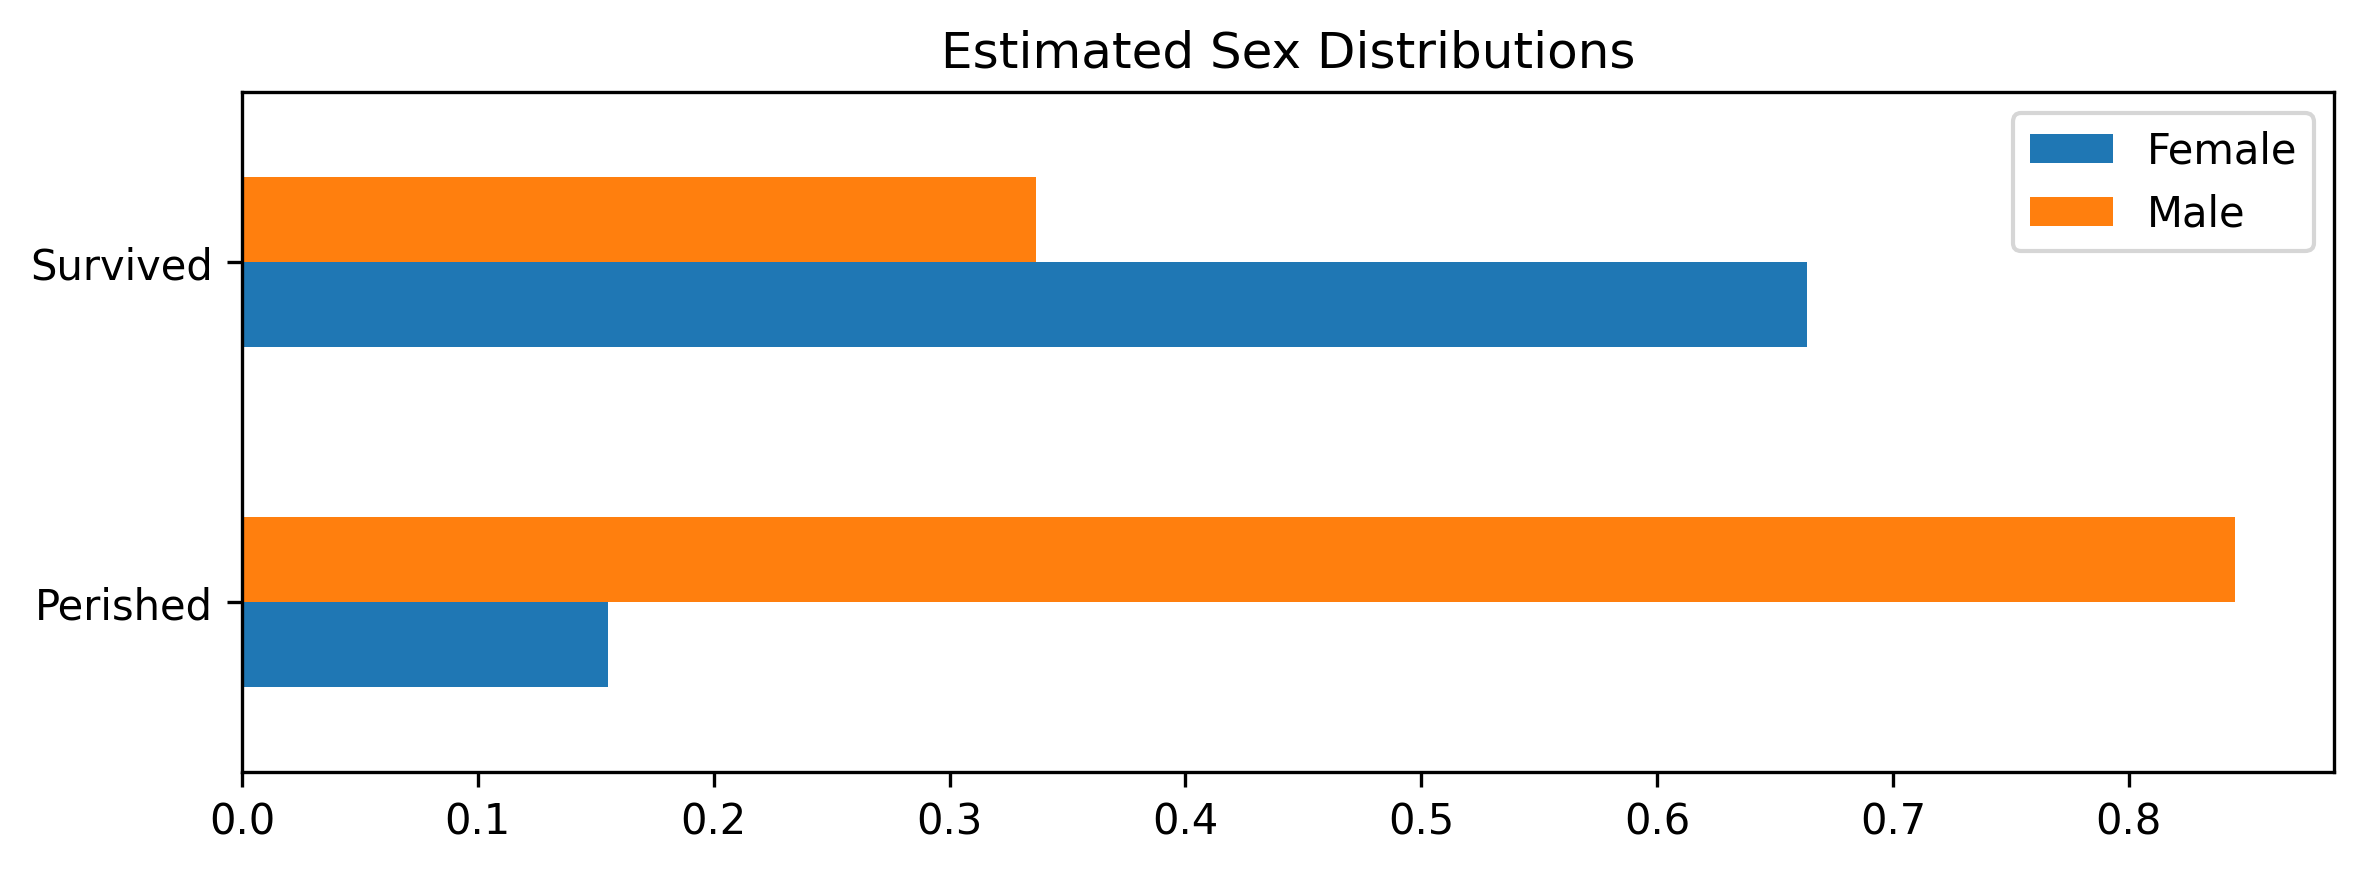

In [11]:
nb = TitanicNaiveBayes().fit(train_data)
nb.plot_sex()

The bar graph above shows the algorithm's estimate for $P(\textrm{Male} \mid \textrm{Survived})$, $P(\textrm{Female} \mid \textrm{Survived})$, $P(\textrm{Male} \mid \textrm{Perished})$, and $P(\textrm{Female} \mid \textrm{Perished})$. Note in particular that $P(\textrm{Male} \mid \textrm{Perished}) \gg P(\textrm{Female} \mid \textrm{Perished})$; this indicates that the algorithm will predict that female passengers on the Titanic are more likely to survive than their male counterparts.

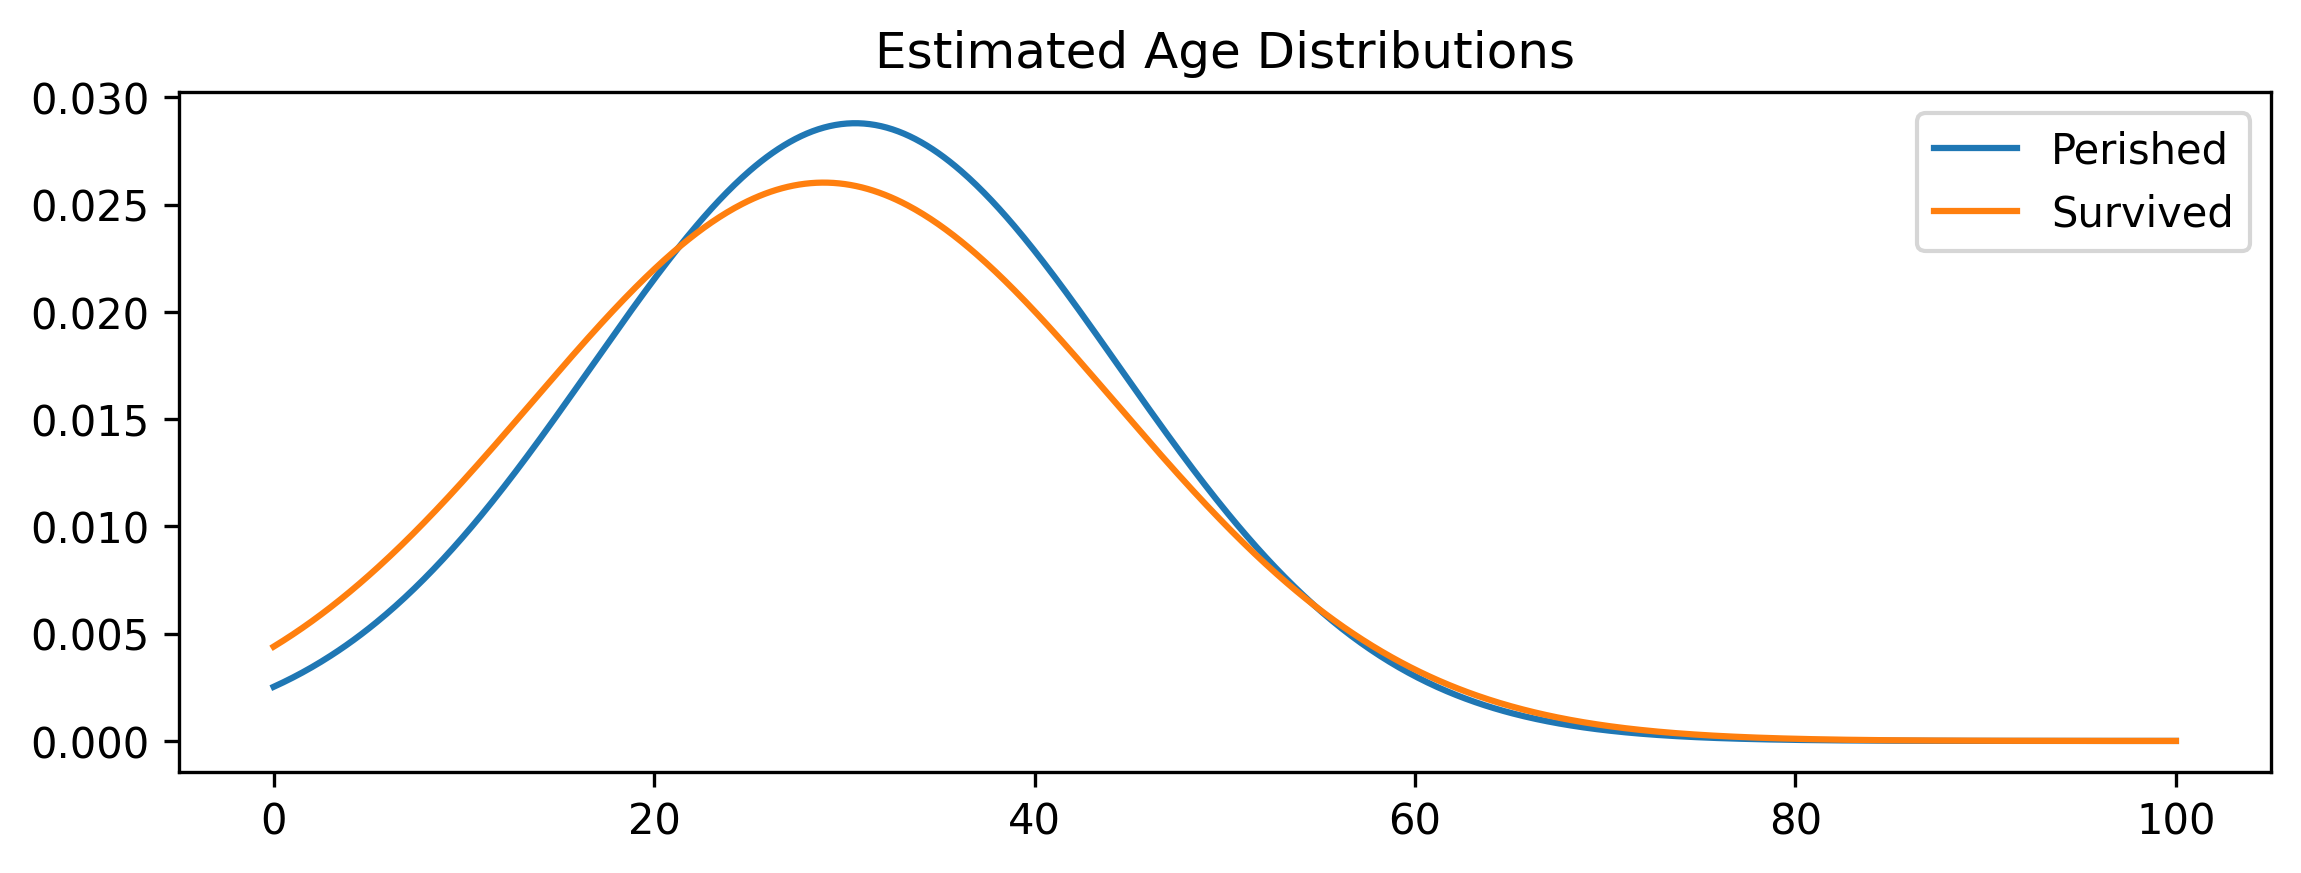

In [12]:
nb.plot_age()

The line graph above shows the age likelihood distributions for survivors and non-survivors estimated by the algorithm. According to the algorithm (and holding all else equal), passengers under the age of 25 are more likely to survive, and passengers over 25 are more likely to perish, but not by much. Thus, the algorithm doesn't learn very much from age or at least the difference isn't as stark as it was for sex. 

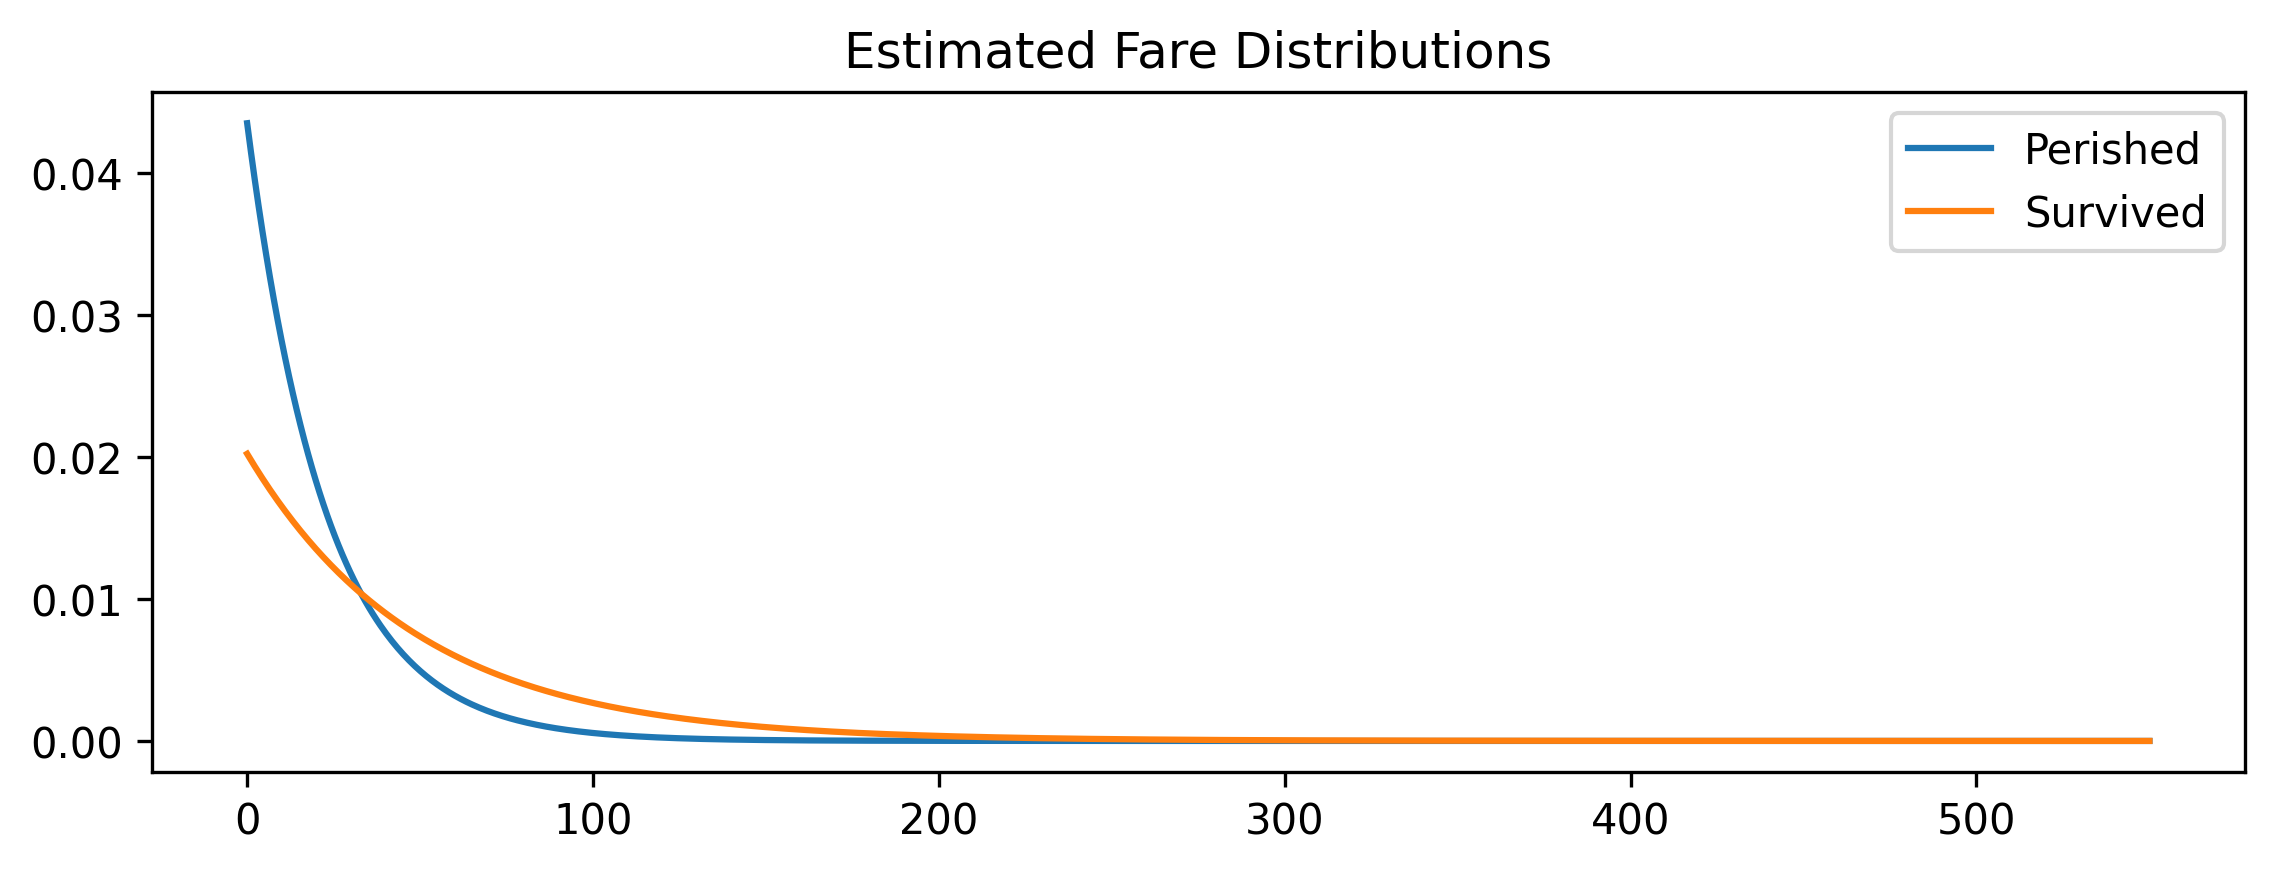

In [13]:
nb.plot_fare()

The line graph above shows the fare likelihood distribution for survivors and non-survivors estimated by the algorithm. This situation is similar to age, but with an exponential distribution instead of a normal distribution. The algorithm will favor survival for passengers with a ticket that is more expensive than about 40 dollars or so (holding everything else equal). Furthermore, the closer the fare is to 0 dollars, the stronger this part of the algorithm will lean towards predicting that the passenger perishes since the gap between the curves increases as the fare decreases. 

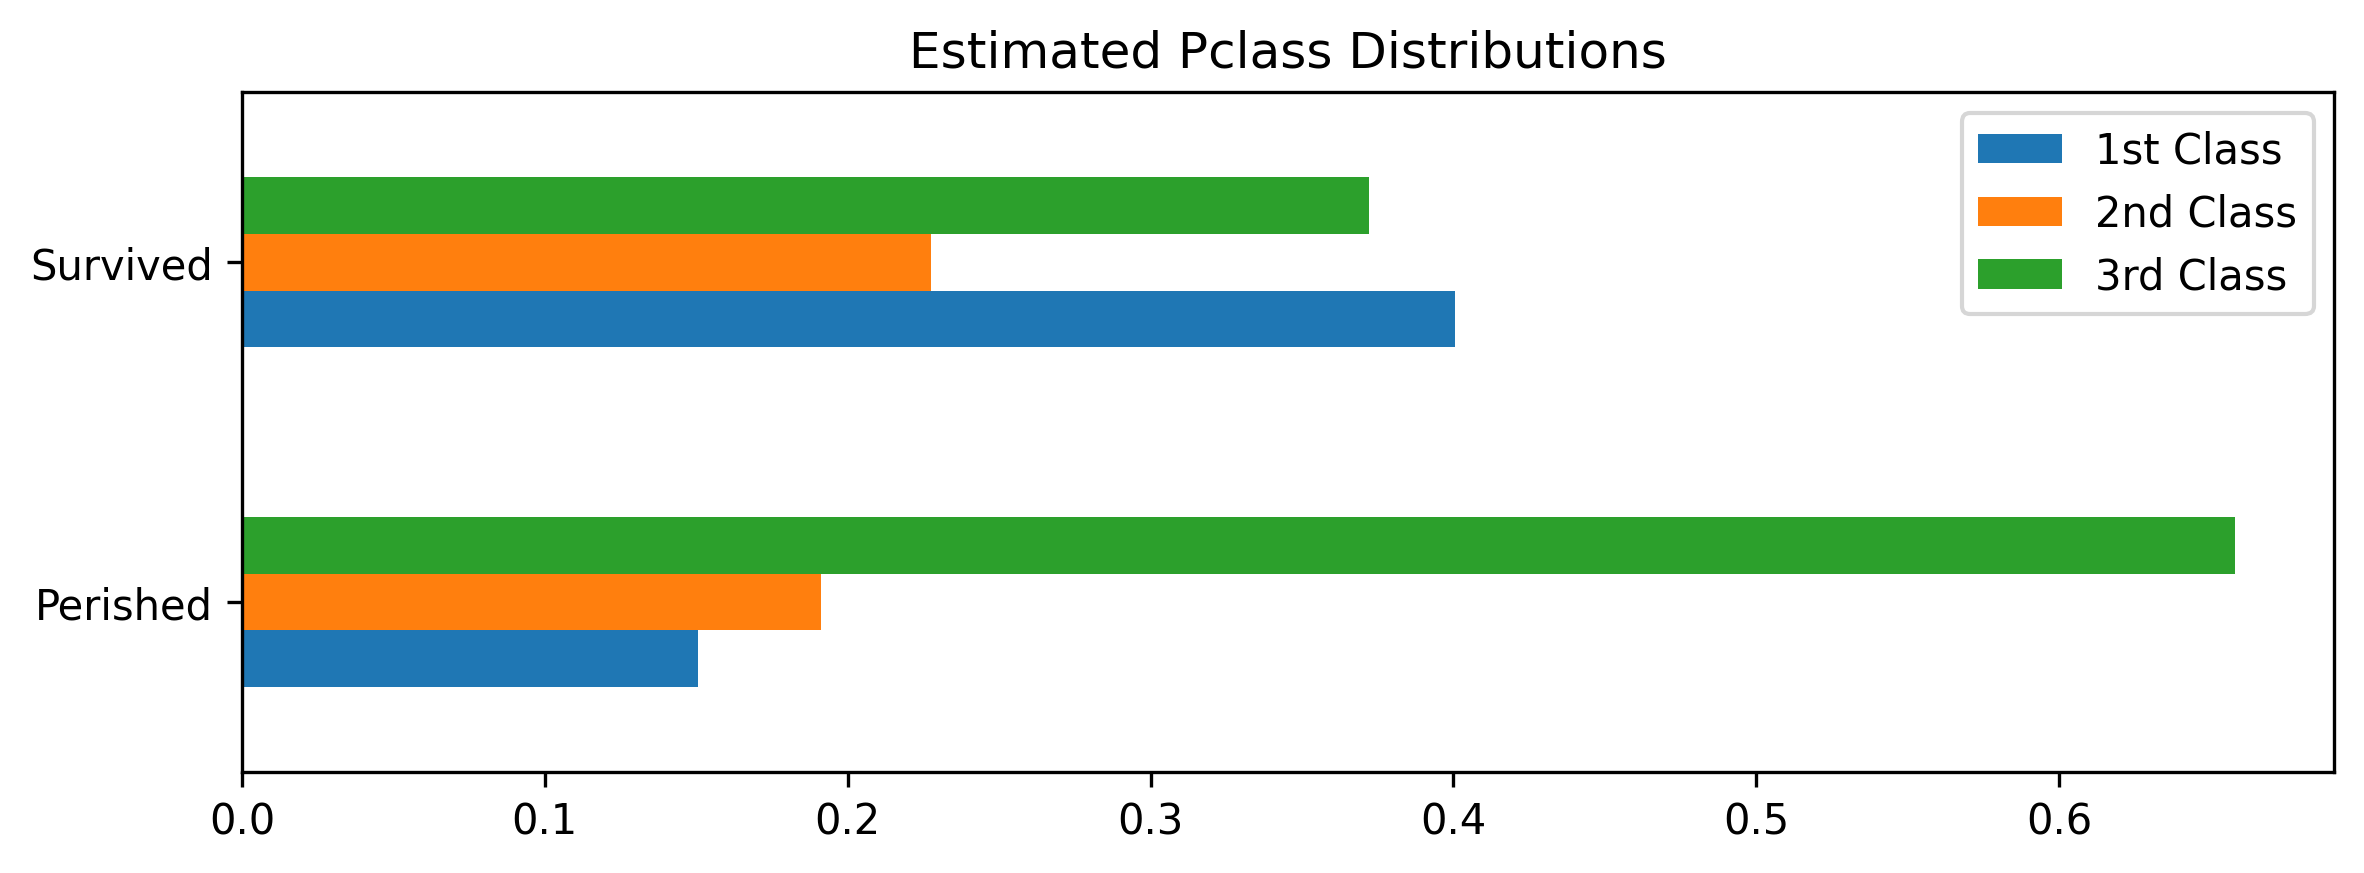

In [14]:
nb.plot_pclass()

The bar graph above shows the Pclass likelihood distribution for survivors and non-survivors estimated by the algorithm. The most obvious takeaway from the graph is that third class passengers are more likely to die compared to their higher-class counterparts as predicted by the algorithm. 

Since we already got our algorithm trained, we'll try the algorithm on a few sample entries of our test data. 

In [15]:
samples = test_data.sample(5)
samples

,Sex,Age,Pclass,Fare
312,male,50.000000,1,211.5000
679,female,9.000000,3,15.2458
1007,female,15.000000,3,8.0292
497,male,40.000000,2,16.0000
865,female,29.901089,3,7.7500


In [16]:
nb.proba(samples)

array([[0.02304901, 0.97695099],
       [0.41708853, 0.58291147],
       [0.49552802, 0.50447198],
       [0.84259868, 0.15740132],
       [0.55219915, 0.44780085]])

In [17]:
nb.predict(samples)

array([1, 1, 1, 0, 0])

In [18]:
test_labels[samples.index]

312     0
679     0
1007    1
497     0
865     0
Name: Survived, dtype: int64

Now we test the algorithm on the entire test set, and get the accuracy percentage of how many labels we predicted correctly. 

In [19]:
nb.accuracy(test_data, test_labels)

0.7715736040609137

An accuracy of 77 percent is not terrible, and it is certainly better than just random guessing, but more sophisticated algorithms can probably do better. This example shows why it can be problematic to assume conditionial independence for all features, even in simple scenarios. However, we emphasize that Naive Bayes is an extremely straightforward and interpretable algorithm. In the following cell, we find the individuals in the test set with the greatest probability of perishing and greatest probability of surviving, respectively, which we can do because Naive Bayes gives us an actual probability estimate for survival not just a binary prediction. 

In [20]:
test_data.iloc[np.argmax(nb.proba(test_data), axis=0)]

,Sex,Age,Pclass,Fare
960,male,34.5,3,6.4375
111,female,24.0,1,263.0000


## Conclusion

In this presentation, we gave an overview of the Naïve Bayes algorithm and implemented it specifically for the Titanic survival problem. With only a limited number of data features in the prediction we obtained reasonable results. However, more sophisticated algorithms (or using more features from the data) would likely outperform our implementation since the features do not satisfy the conditional independence assumption.

## Appendix: More Data Visualizations

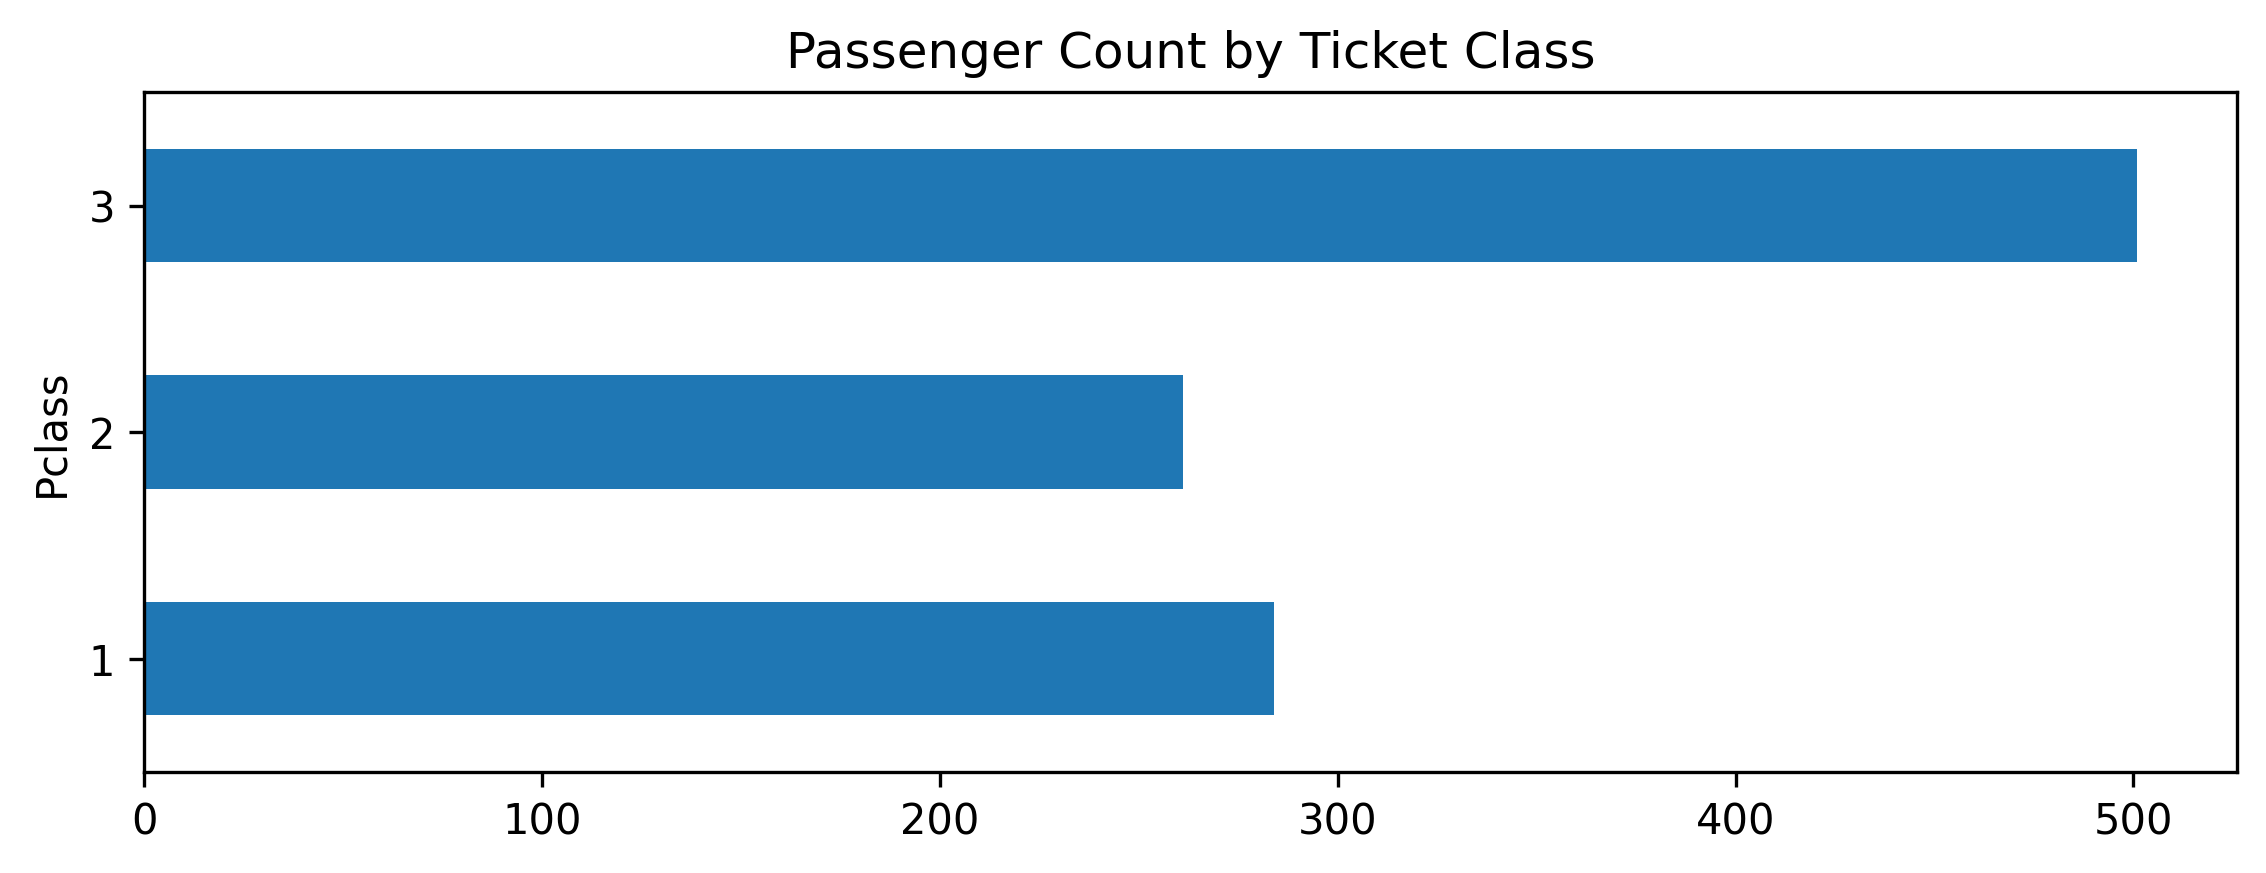

In [21]:
titanic.groupby("Pclass").count()["Age"].plot(kind="barh")
plt.title("Passenger Count by Ticket Class")
plt.show()

The bar graph above shows the number of passengers in the data that are in each class based on the ticket. From the bar graph, the majority of passengers, recorded in the data, are in 3rd class followed by 1st and 2nd class by a relatively small gap between the two higher classes. 

In [22]:
titanic.describe()

,Survived,Age,Pclass,Fare
count,1309.000000,1046.000000,1309.000000,1308.000000
mean,0.381971,29.881135,2.294882,33.295479
std,0.486055,14.413500,0.837836,51.758668
min,0.000000,0.166700,1.000000,0.000000
25%,0.000000,21.000000,2.000000,7.895800
50%,0.000000,28.000000,3.000000,14.454200
75%,1.000000,39.000000,3.000000,31.275000
max,1.000000,80.000000,3.000000,512.329200


This table gives detailed summary statistics for each of the featues in the training data. From the table, we can see that: 
- The mean age of the passsengers in the Titanic was 29-30 years old, but the median age is about 28 years old, which confirms the right-skewness of the distribution of ages. The youngest passenger was a baby while the oldest passenger is 80 years old. 
- A good majority of passengers recorded bought 3rd class tickets though the mean (average) was is about 2nd class. 
- The mean fare of the passengers in the Titanic was about \\$33.50 dollars, but the median fare was only about \\$14.50, dollars which confirms the extreme right-skewness of the distribution of fare. The cheapest ticket was for free while the most expensive ticket was about 512.33 dollars. 

**Missing data**

In [23]:
titanic.isnull().sum()

Survived      0
Sex           0
Age         263
Pclass        0
Fare          1
dtype: int64

The table above shows all the passengers in the data whose ages are unknown so far. According to the table, there are 263 entries or passengers whose ages were not recorded and one passenger with a missing ticket fare.

**Survived Classification Data Summary**

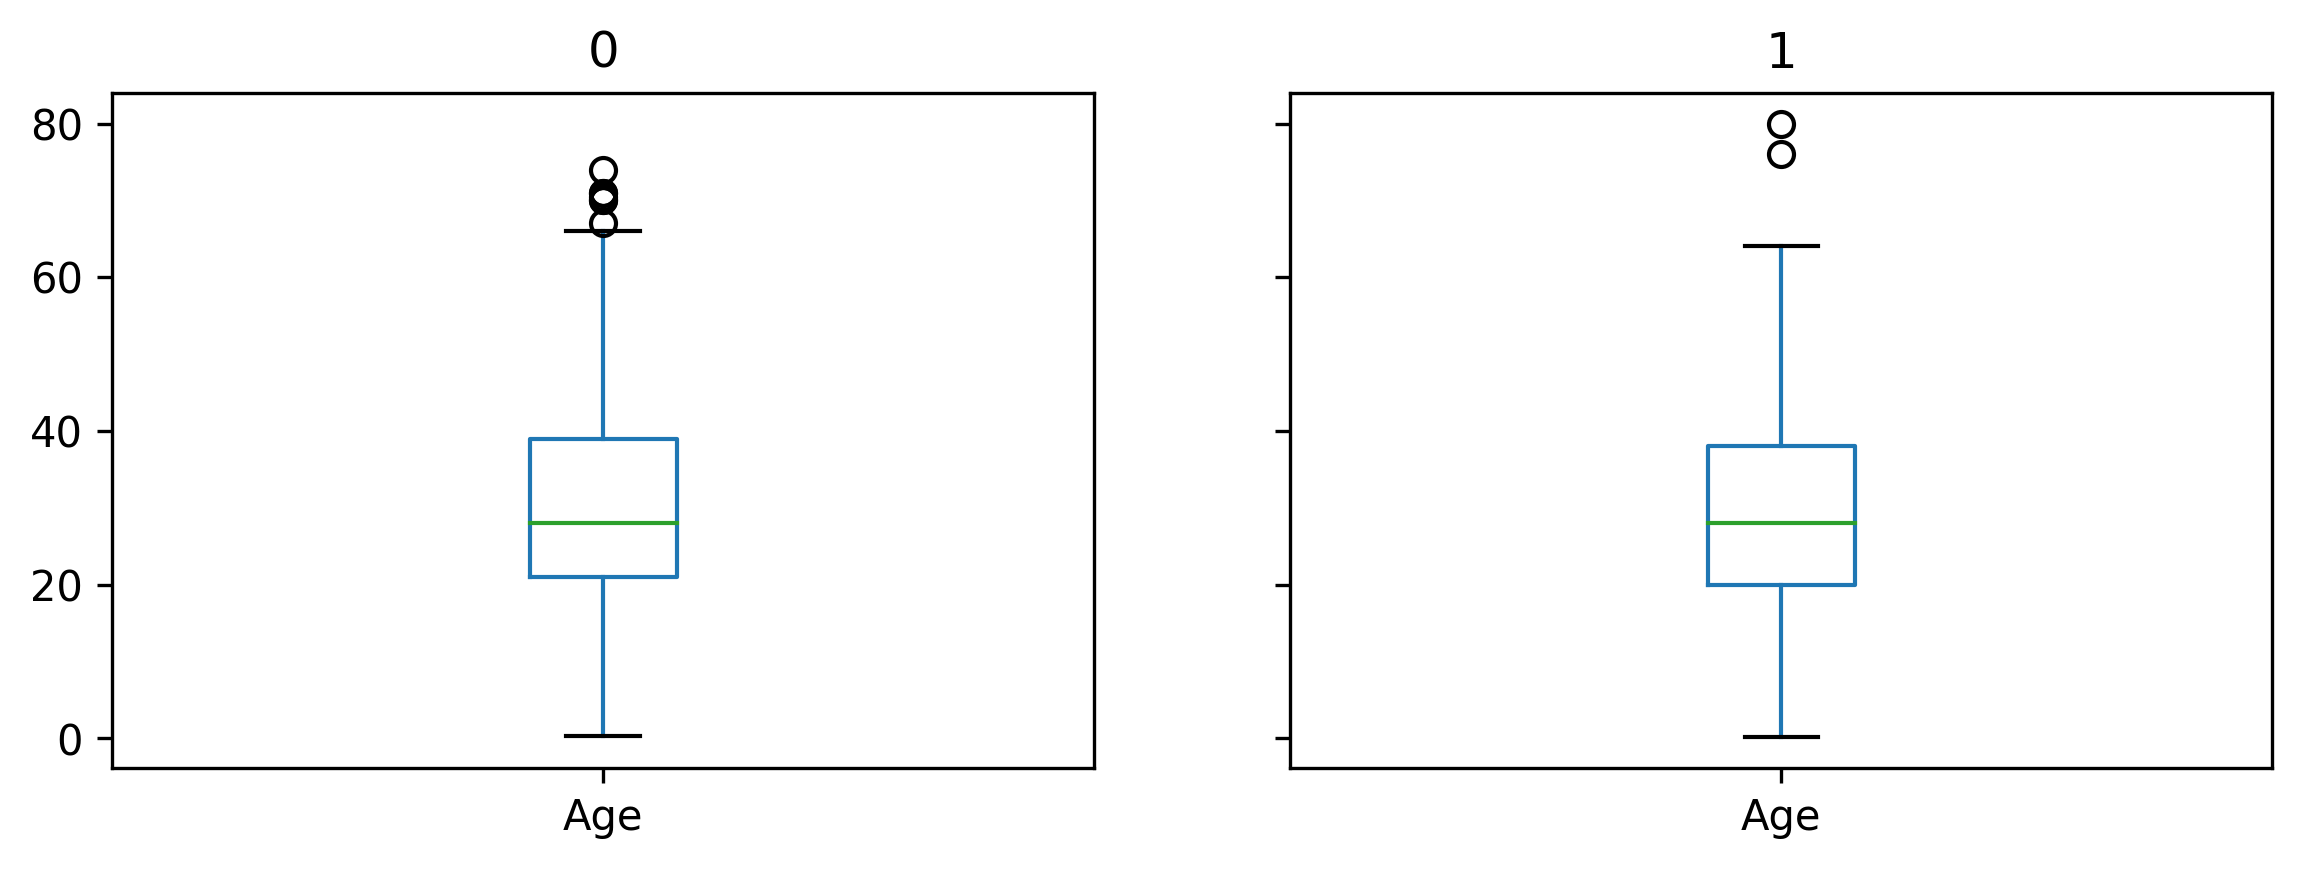

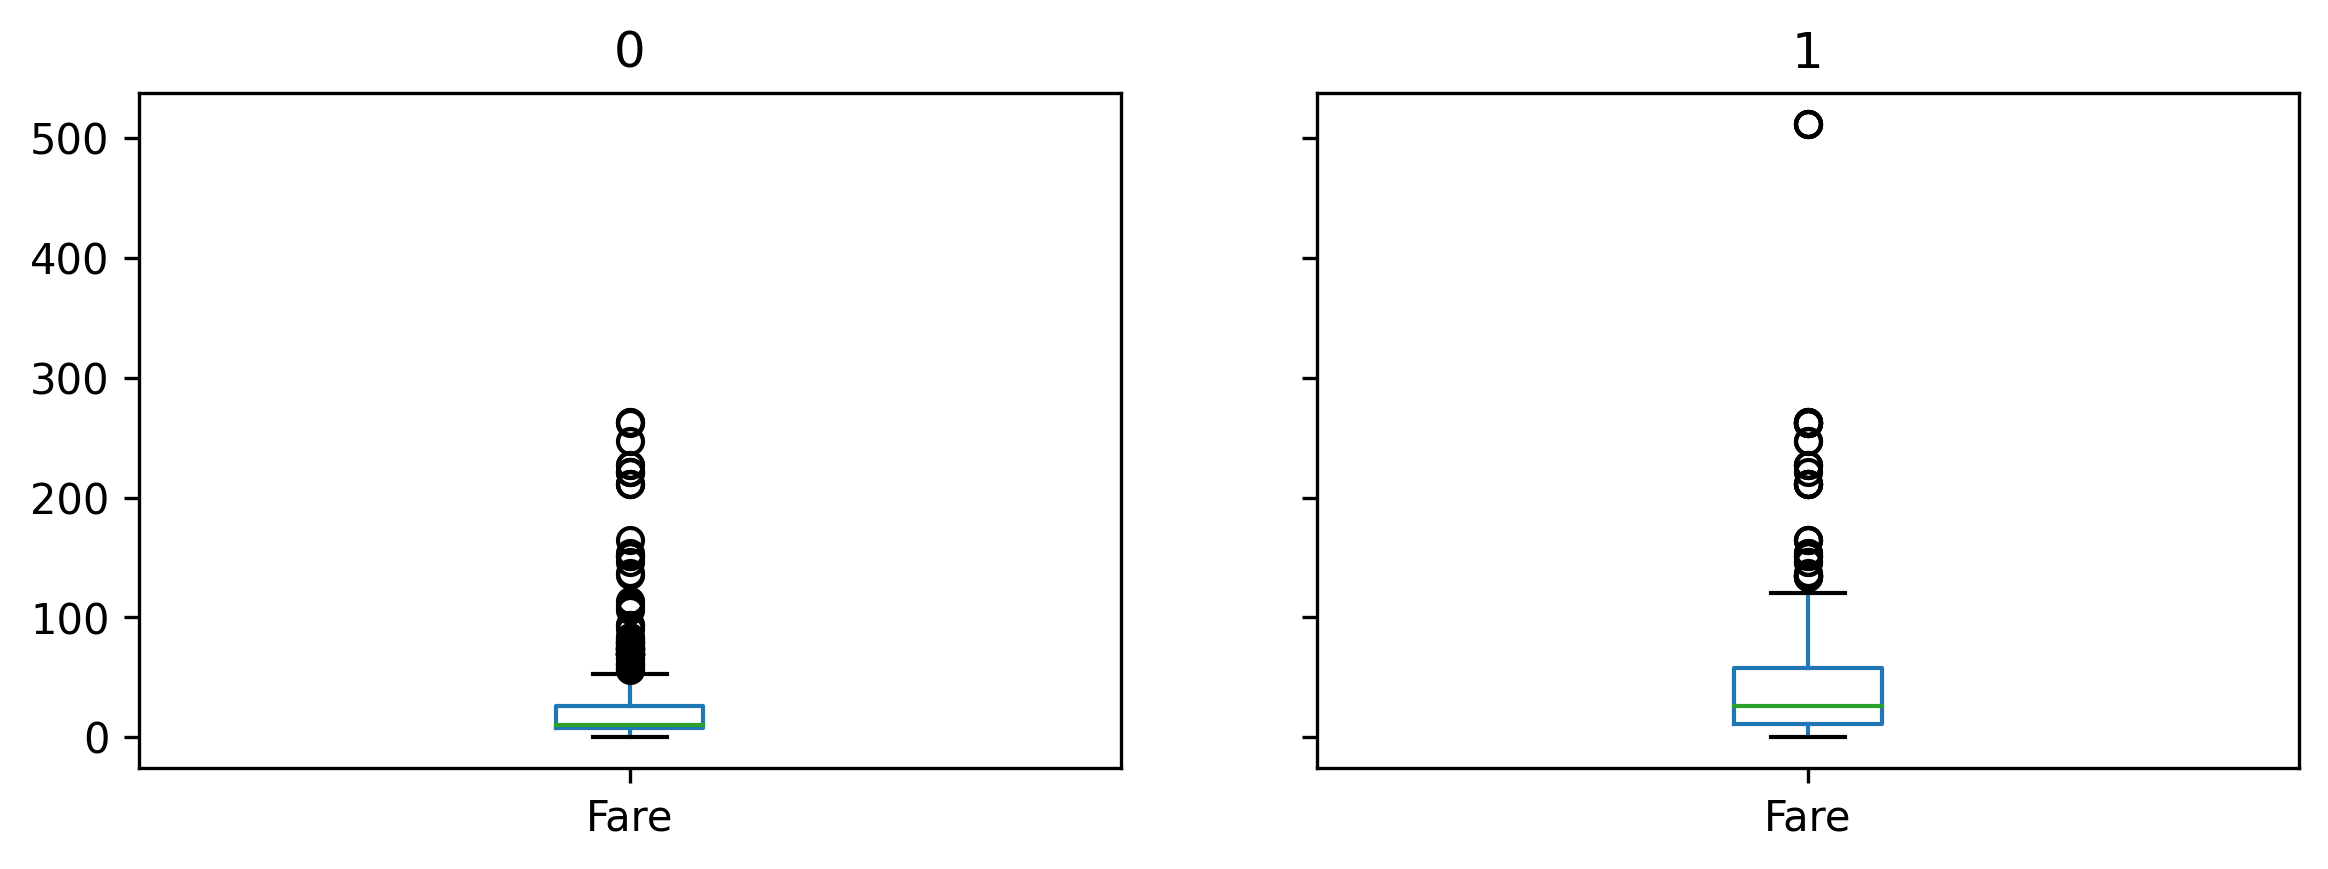

In [24]:
survival_groups = titanic.groupby("Survived")
survival_groups.boxplot(grid=False, column=['Age'], layout=(1,2))
survival_groups.boxplot(grid=False, column=['Fare'], layout=(1,2))
plt.show()

The box plots above show the distributions of age and fare based on survival/non-survival. While it may seem that survivors may be slightly older and bought slightly more expensive tickets on average compared to their non-survivor counterparts, there are a lot of outliers all the boxplots.

**Pclass Classification Data Summary**

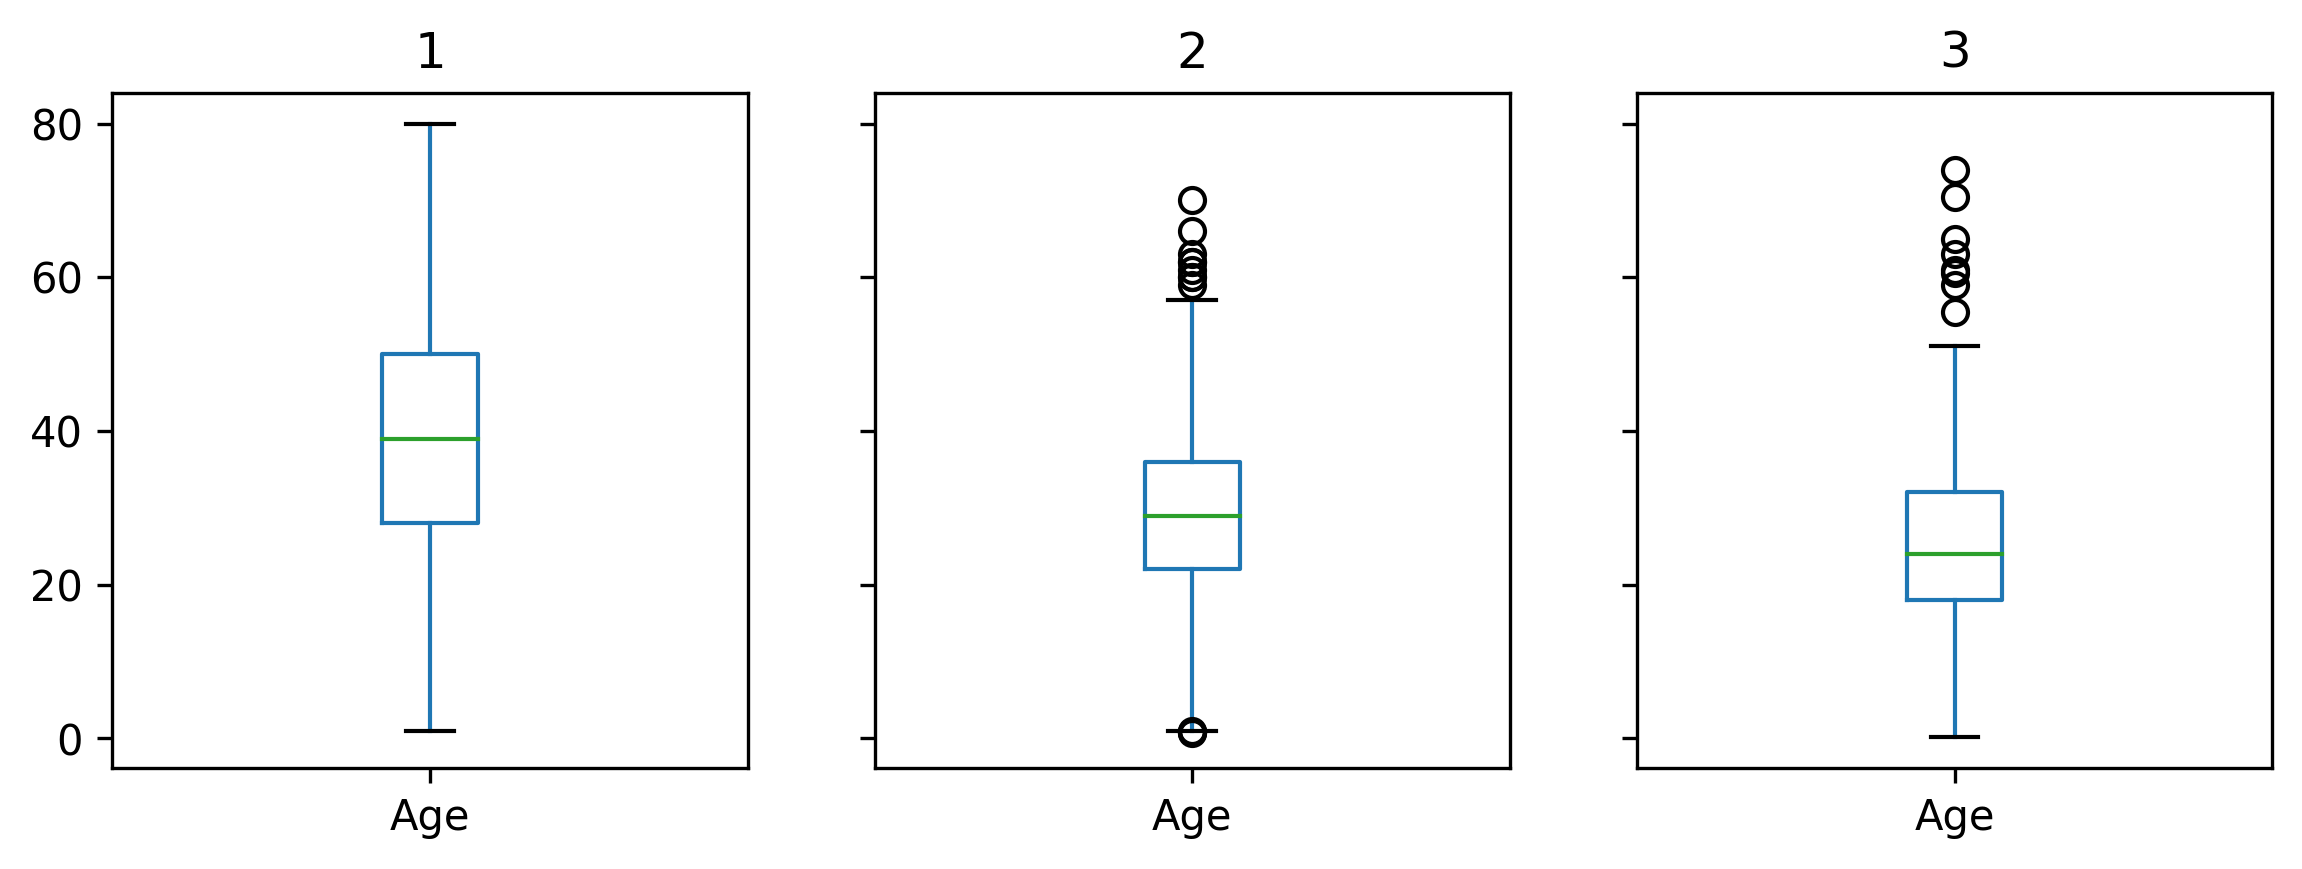

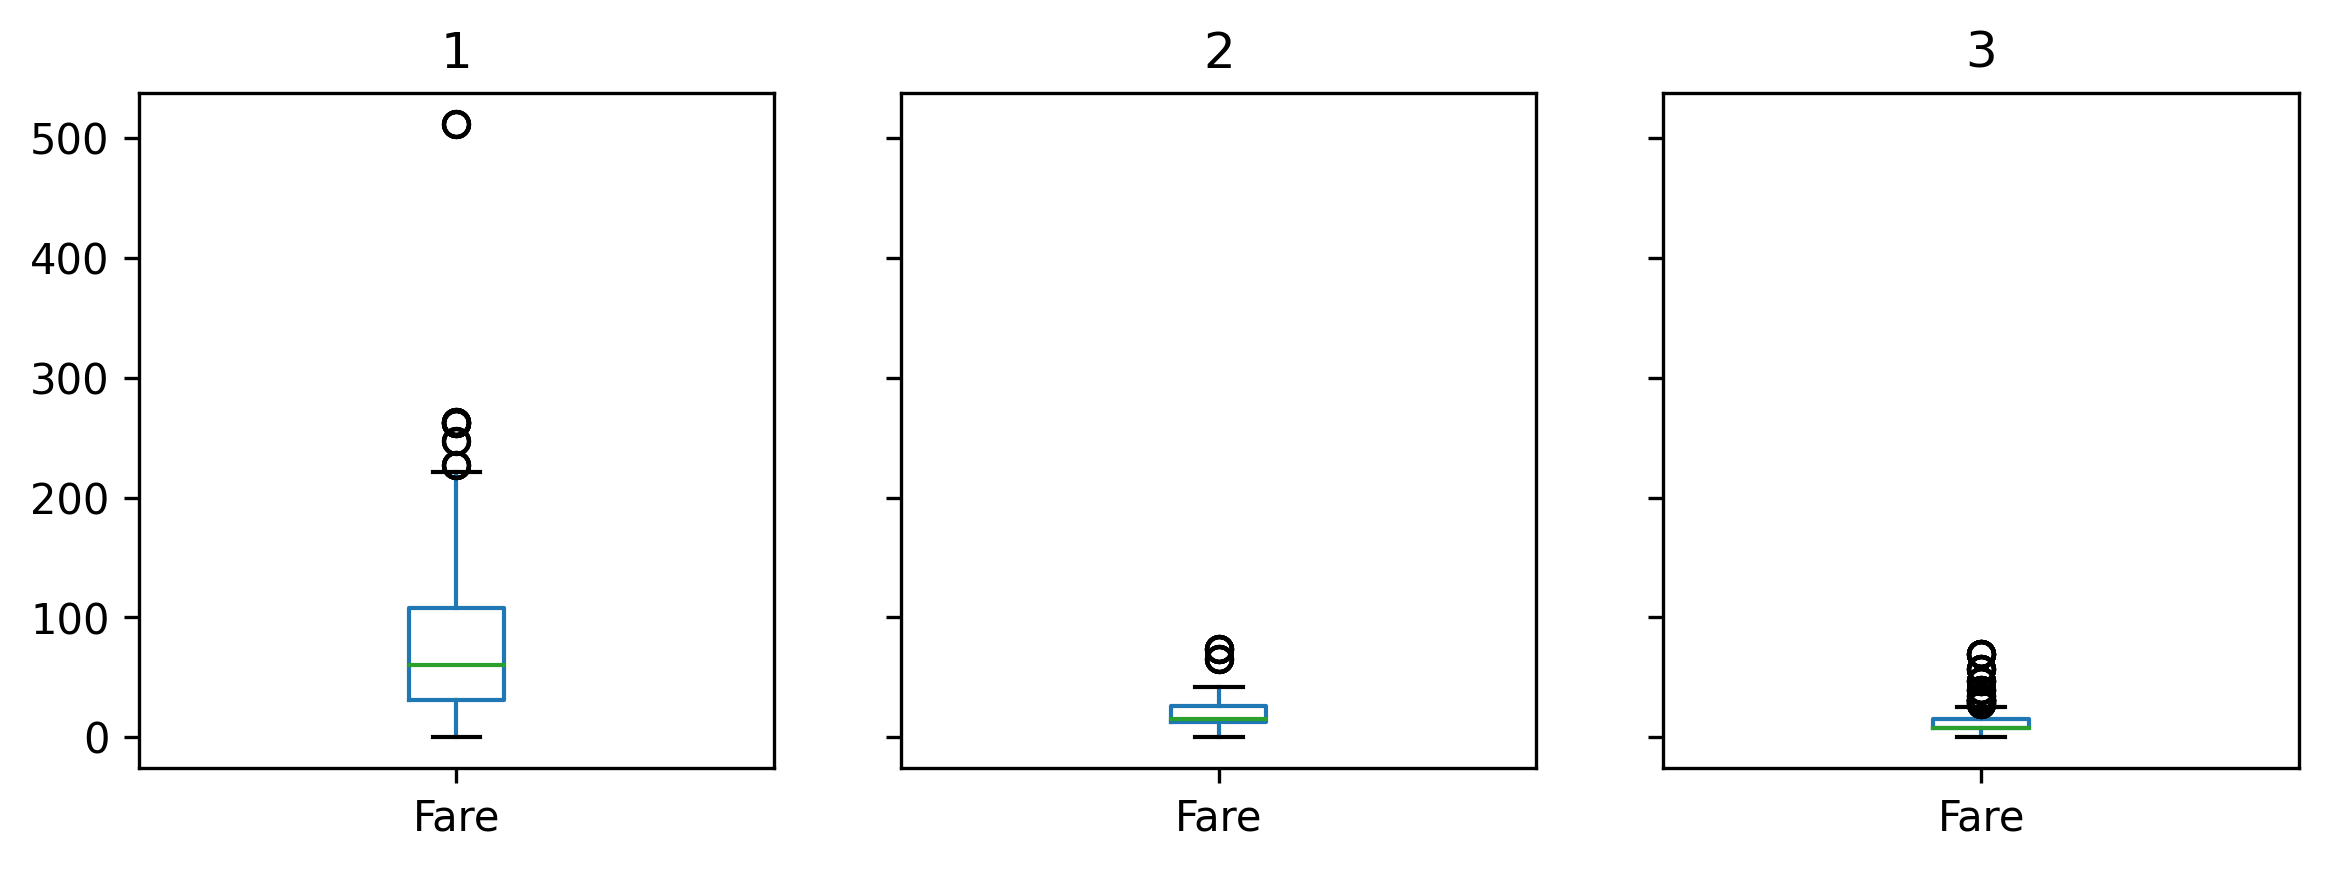

In [25]:
groups = titanic.groupby("Pclass")
groups.boxplot(grid=False, column=['Age'], layout=(1,3))
groups.boxplot(grid=False, column=['Fare'], layout=(1,3))
plt.show()

The box plots above show the distributions of age and fare based on Pclass (1, 2, 3). 

There are no outliers in the distribution of age in the 1st class, but there are many outliers in the other classes in terms of age, especially 3rd class passengers since there is more data collected for 3rd class compared to the 2 higher classes. The average age of 1st class passengers is older than the other two classes, and the average age decreases as we get lower in class. 

There are outliers in the distributions of fare for all classes, especially 1st class since we expect that more expensive tickets are brought through this class. There are a lot of outliers for the distribution of fare for 3rd class passengers not just only because we expect the cheapest tickets from this class, but also how there is more data collected from this class as well. The average fare of 1st class passengers is obviously higher/more expensive than the other two classes, and the average fare decreases as we get lower in class. 

**Sex Classification Data Summary**

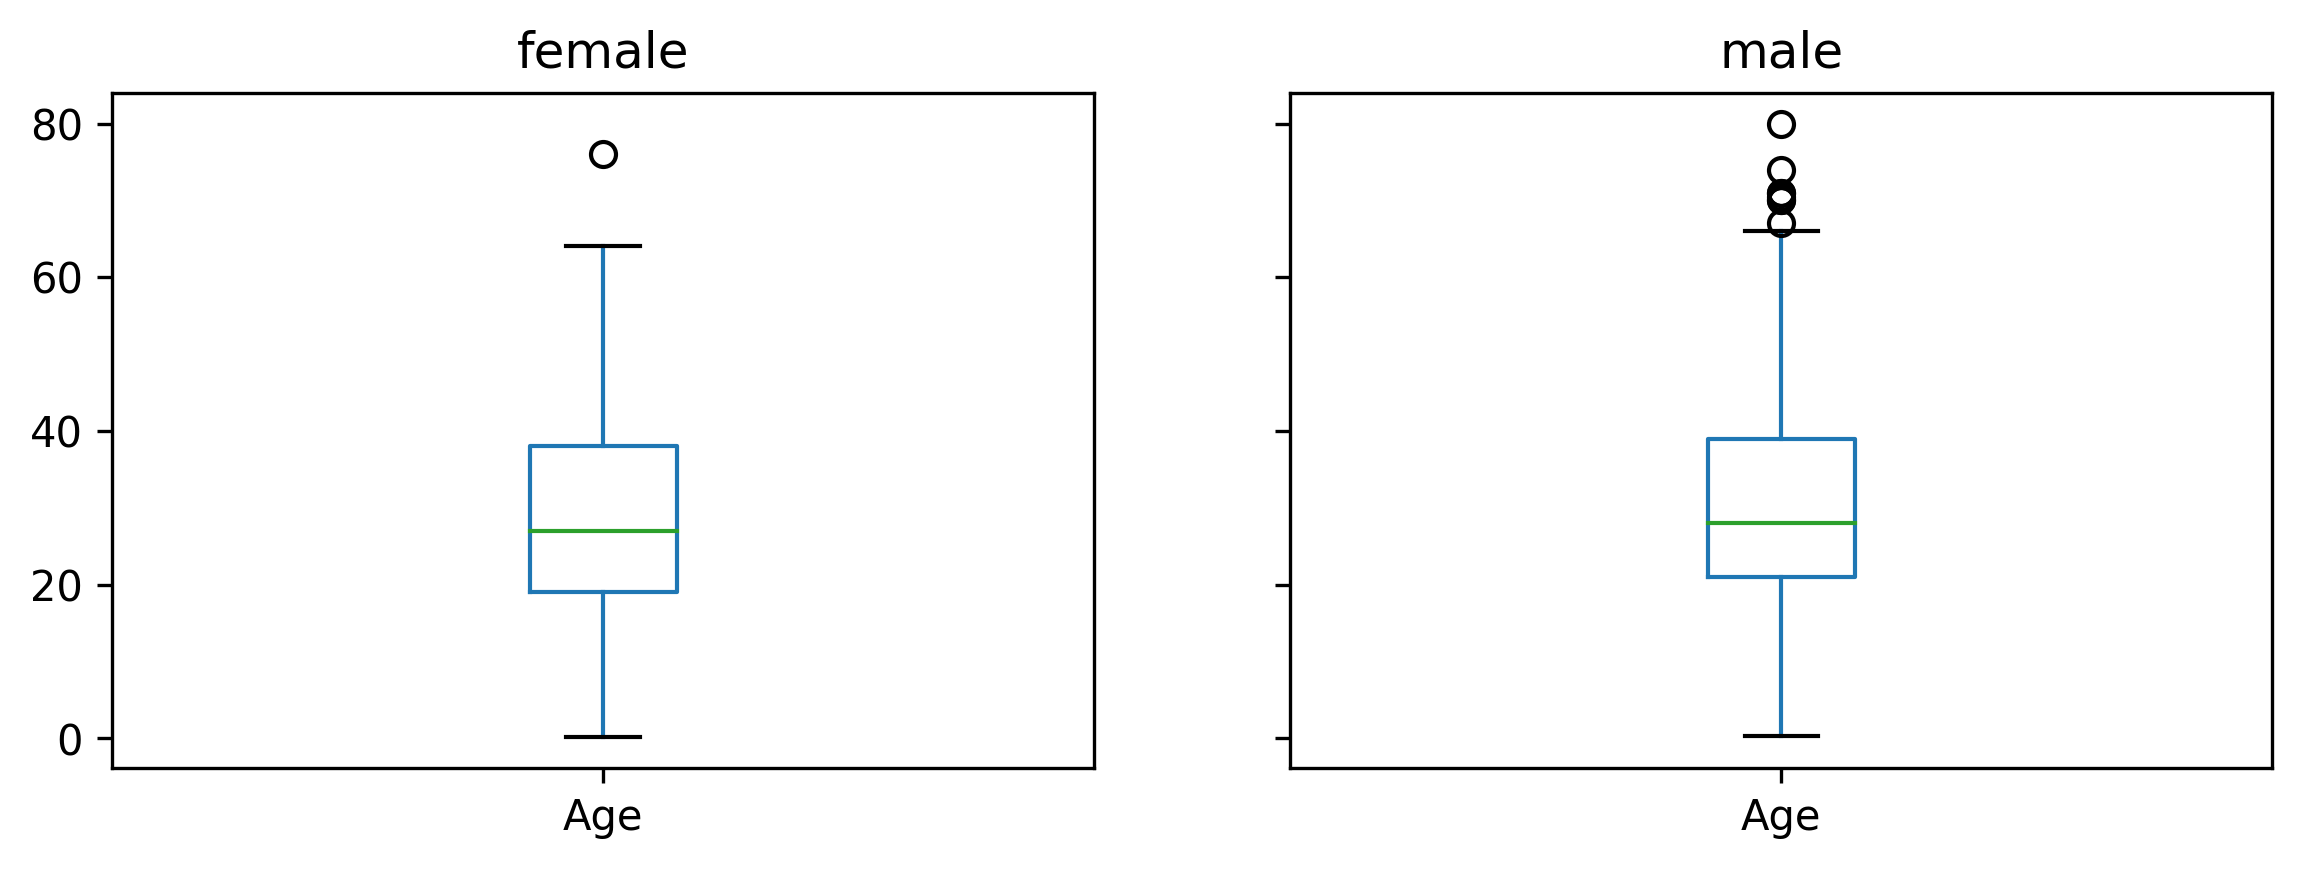

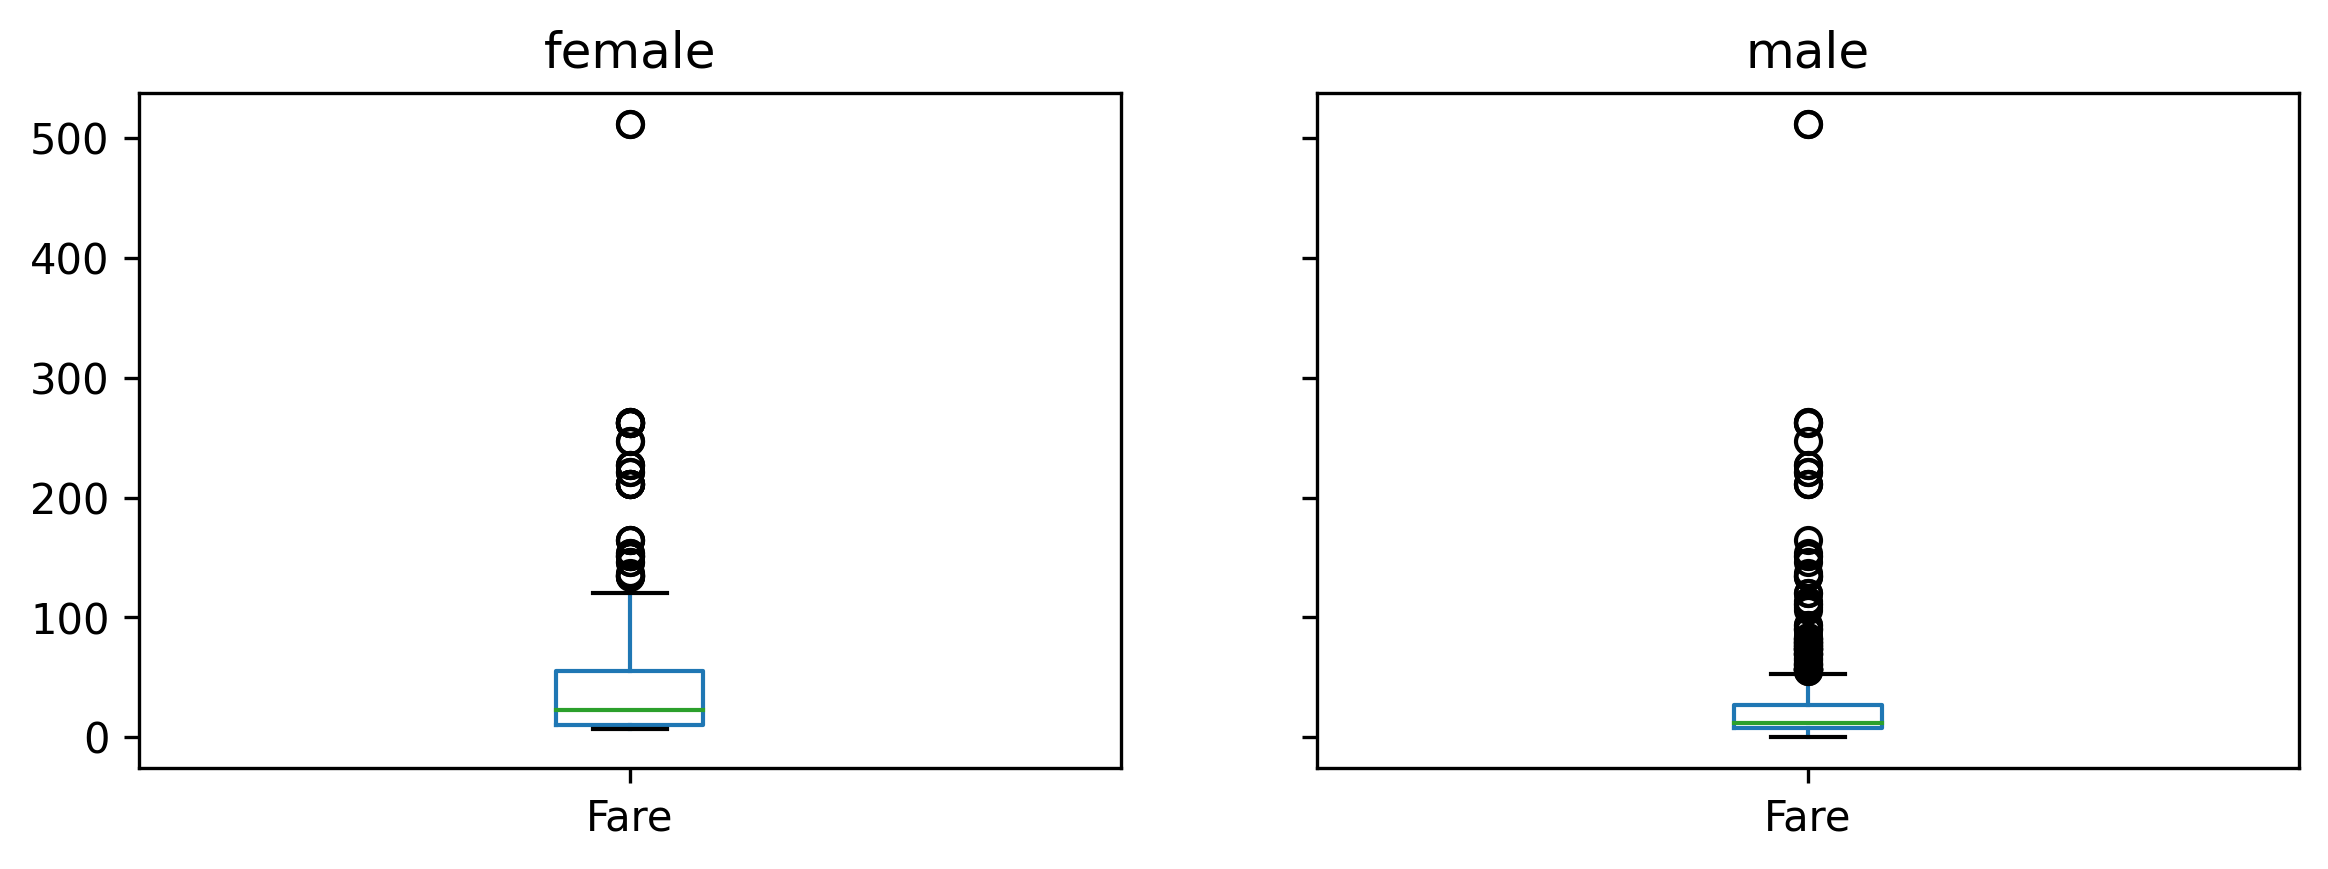

In [26]:
gender_groups = titanic.groupby("Sex")
gender_groups.boxplot(grid=False, column=['Age'], layout=(1,2))
gender_groups.boxplot(grid=False, column=['Fare'], layout=(1,2))
plt.show()

The box plots above show the distributions of age and fare based on sex (male/female). There is only one outlier in the age distribution of females while there are multiple outliers in the age distribution of males. The average age of males and females is about the same, but with average age of males slightly higher. Then, there are a lot of outliers in the female and male distributions of fare. The average fare of males is slightly lower than females. Since passengers of cheaper tickets or older age are more likely to perish in the Titanic, it could be possible that sex played a significant role in who gets to survive and who doesn't in the Titanic. 

**Age and Fare as Classification**

In [27]:
# Partition the passengers into 3 categories based on age.
age = pd.cut(titanic['Age'], [0, 12, 18, 80])
age

titanic.pivot_table(values='Survived', index=['Sex', age],
                   columns='Pclass', aggfunc='mean')

Pclass                  1         2         3
Sex    Age                                   
female (0, 12]   0.000000  1.000000  0.466667
       (12, 18]  1.000000  0.875000  0.607143
       (18, 80]  0.966667  0.878049  0.436170
male   (0, 12]   1.000000  1.000000  0.342857
       (12, 18]  0.500000  0.000000  0.081081
       (18, 80]  0.328671  0.087591  0.158845

This is a two-way table of survival rate between sex and then age divided into intervals (children (0-12), teen (12-18), and adult (18-80)), and Pclass (1, 2, 3). (Sex + Age vs PClass / PClass vs Sex + Age)

Groups with everyone surviving: 
- 2nd class female children
- 1st class female teenagers
- 1st class male children
- 2nd class male children

In [28]:
titanic.pivot_table(values='Survived', index=['Sex', age],
                   columns='Pclass', aggfunc='count')

Pclass             1    2    3
Sex    Age                    
female (0, 12]     1   13   30
       (12, 18]   12    8   28
       (18, 80]  120   82   94
male   (0, 12]     4   11   35
       (12, 18]    4   10   37
       (18, 80]  143  137  277

This is a two-way table of number of survivors between sex and then age divided into intervals (children (0-12), teen (12-18), and adult (18-80)), and Pclass (1, 2, 3). (Sex + Age vs PClass / PClass vs Sex + Age)

In [29]:
# Cut the ticket price into two intervals (cheap vs expensive)
fare = pd.qcut(titanic['Fare'], 2)
fare

titanic.pivot_table(values='Survived',
                   index=['Sex', age], columns=[fare, 'Pclass'],
                   aggfunc='count', fill_value='-')

Fare            (-0.001, 14.454]            (14.454, 512.329]            
Pclass                         1   2      3                 1     2     3
Sex    Age                                                               
female (0, 12]                 -   -    7.0               1.0  13.0  23.0
       (12, 18]                -   4   23.0              12.0   4.0   5.0
       (18, 80]                -  30   64.0             120.0  52.0  30.0
male   (0, 12]                 -   -    8.0               4.0  11.0  27.0
       (12, 18]                -   5   26.0               4.0   5.0  11.0
       (18, 80]                5  84  240.0             138.0  53.0  36.0

This is a two-way table of number of survivors between sex and then age divided into intervals (children (0-12), teen (12-18), and adult (18-80)), and fare divided into intervals (cheap (0-14.454) and expensive-ish (14.454, 512.329)) and then Pclass (1, 2, 3). (Sex + Age vs Fare + PClass / Fare + PClass vs Sex + Age)

**Age and Fare Correlation**

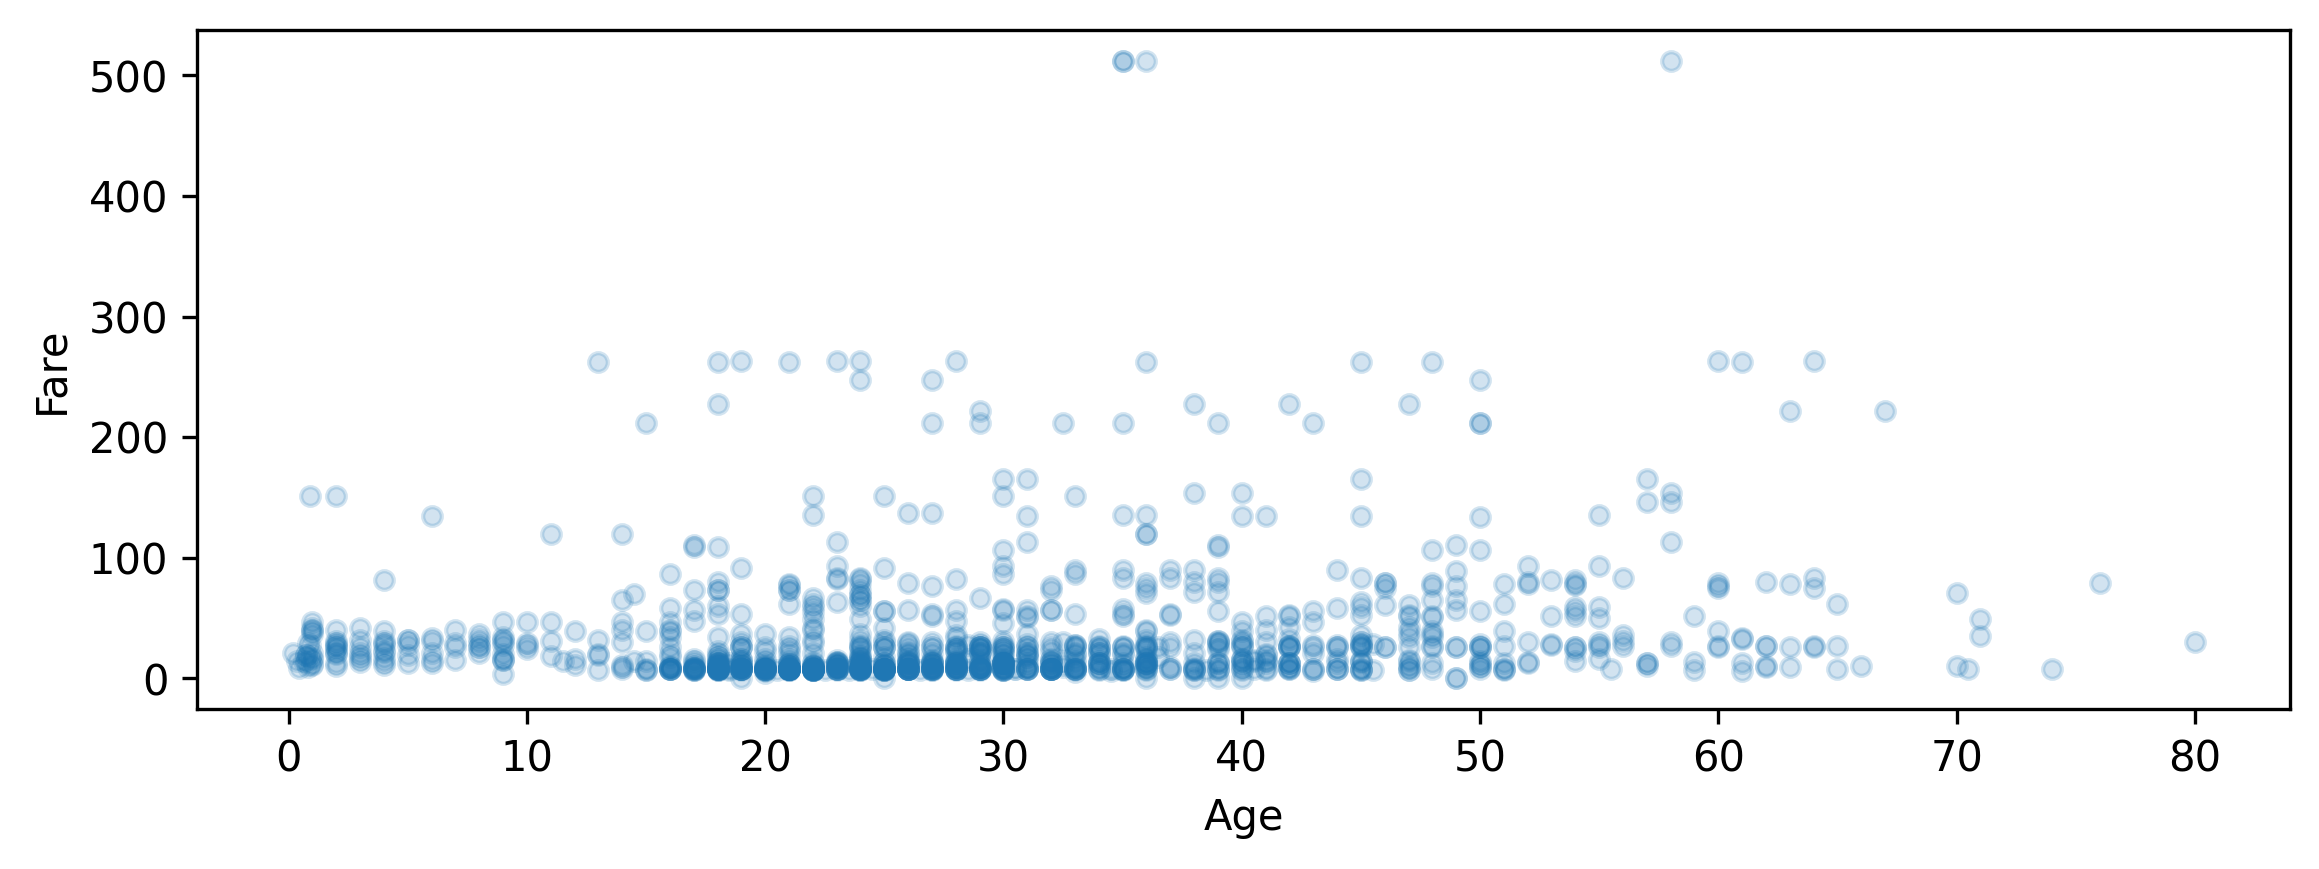

In [30]:
titanic.plot(kind='scatter', x='Age', y='Fare', alpha=.2)

There is a weak correlation between age and fare based on the graph above. 